# CS 145 COVID Prediction

## Loading Data

First we need to load the data, which is stored in CSV files separated by date

In [1013]:
import numpy as np
import pandas as pd
import glob
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

In [1014]:
# grab filepaths for every csv file
datapath = 'data/csse_covid_19_daily_reports_us/*.csv'
datafiles = np.array(glob.glob(datapath))
print(datafiles[138:142])

['data/csse_covid_19_daily_reports_us\\08-28-2020.csv'
 'data/csse_covid_19_daily_reports_us\\08-29-2020.csv'
 'data/csse_covid_19_daily_reports_us\\08-30-2020.csv'
 'data/csse_covid_19_daily_reports_us\\08-31-2020.csv']


In [1015]:
# init giant df
data = pd.read_csv(datafiles[0])
# read and append each csv to the master df
for i in range(1, len(datafiles)):
    df = pd.read_csv(datafiles[i])
    data = data.append(df, ignore_index = True)
# only keep 50 states
data.drop(data[data.Province_State.isin(['Diamond Princess', 'District of Columbia', 'Grand Princess', 'Guam', 'Puerto Rico', 'American Samoa', 'Northern Mariana Islands', 'Recovered', 'Virgin Islands'])].index, inplace = True)
data.drop(columns = ['Country_Region', 'FIPS', 'UID', 'ISO3'], inplace = True)
data['Last_Update'] = data['Last_Update'].astype('datetime64[ns]')
data = data.reset_index(drop=True)
data.loc[48:52, ]

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
48,Wisconsin,2020-04-12 23:18:15,44.2685,-89.6165,3341,144,NaN,3197.0,64.565739,39257.0,974.0,4.310087,758.652263,29.152948
49,Wyoming,2020-04-12 23:18:15,42.7560,-107.3025,270,0,137.0,270.0,54.299735,5459.0,40.0,0.000000,1097.860188,14.814815
50,Alabama,2020-04-13 23:07:54,32.3182,-86.9023,3734,99,NaN,3635.0,79.634933,29182.0,457.0,2.651312,622.363852,12.238886
51,Alaska,2020-04-13 23:07:54,61.3707,-152.4044,277,8,85.0,269.0,46.340521,7830.0,32.0,2.888087,1309.914362,11.552347
52,Arizona,2020-04-13 23:07:54,33.7298,-111.4312,3705,122,NaN,3583.0,50.901828,43347.0,525.0,3.292848,595.530778,14.170040


## Data Cleaning

We will add a parameter for the number of days since Jan 1st, which will eventually replace the timestamps.

In [1016]:
'''
import datetime
# add a column for days since Jan 1st(will eventually remove timestamp)
# too lazy to vectorize
days = np.zeros(len(data.index))
for i in range(len(data.index)):
    days[i] = (data['Last_Update'][i].date() - datetime.date(2020, 1, 1)).days
data['days'] = days
'''

"\nimport datetime\n# add a column for days since Jan 1st(will eventually remove timestamp)\n# too lazy to vectorize\ndays = np.zeros(len(data.index))\nfor i in range(len(data.index)):\n    days[i] = (data['Last_Update'][i].date() - datetime.date(2020, 1, 1)).days\ndata['days'] = days\n"

In [1017]:
data = pd.concat([data, pd.get_dummies(data['Province_State'])], axis = 1)
statenames = np.unique(data['Province_State'])
#data.drop(columns = ['Province_State'], inplace = True)
names = list(data.columns.values)
timestamps = data['Last_Update']
states = data['Province_State']
data.head()

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,Alabama,2020-04-12 23:18:15,32.3182,-86.9023,3563,93,NaN,3470.0,75.988020,21583.0,...,0,0,0,0,0,0,0,0,0,0
1,Alaska,2020-04-12 23:18:15,61.3707,-152.4044,272,8,66.0,264.0,45.504049,8038.0,...,0,0,0,0,0,0,0,0,0,0
2,Arizona,2020-04-12 23:18:15,33.7298,-111.4312,3542,115,NaN,3427.0,48.662422,42109.0,...,0,0,0,0,0,0,0,0,0,0
3,Arkansas,2020-04-12 23:18:15,34.9697,-92.3731,1280,27,367.0,1253.0,49.439423,19722.0,...,0,0,0,0,0,0,0,0,0,0
4,California,2020-04-12 23:18:15,36.1162,-119.6816,22795,640,NaN,22155.0,58.137726,190328.0,...,0,0,0,0,0,0,0,0,0,0


In [1018]:
data.shape

(9650, 64)

We impute NA values using KNN with k = 10.

In [1019]:
imputer = KNNImputer(n_neighbors=10, weights="uniform")
data = pd.DataFrame(data = imputer.fit_transform(data.drop(columns = ['Province_State', 'Last_Update'])), columns = names[2:])
data = pd.concat([states, timestamps, data], axis = 1)
data.head()

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,Alabama,2020-04-12 23:18:15,32.3182,-86.9023,3563.0,93.0,780.3,3470.0,75.988020,21583.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alaska,2020-04-12 23:18:15,61.3707,-152.4044,272.0,8.0,66.0,264.0,45.504049,8038.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arizona,2020-04-12 23:18:15,33.7298,-111.4312,3542.0,115.0,1378.2,3427.0,48.662422,42109.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arkansas,2020-04-12 23:18:15,34.9697,-92.3731,1280.0,27.0,367.0,1253.0,49.439423,19722.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,California,2020-04-12 23:18:15,36.1162,-119.6816,22795.0,640.0,4283.8,22155.0,58.137726,190328.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Additional Features

We will hard code each state's overall political stance in 2020, with 3 indicating safe, 2 indicating likely, 1 indicating leaning, and 0 indicating none. Thus the parameters "dem" and "rep" are ordinal while "swing" is a dummy variable. Because Maine and Nebraska allow split voting, we will consider Maine likely democratic and Nebraska likely republican. The source of the data is from https://www.270towin.com/

We will also include whether a state has enacted a mandatory mask mandate, the data for which is from [Axios](https://www.axios.com/states-face-coverings-mandatory-a0e2fe35-5b7b-458e-9d28-3f6cdb1032fb.html). This will be dummy coded.

In [1020]:
dem = [0, 0, 1, 0, 3, 2, 3, 3, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 2, 3, 3, 1, 2, 0, 0, 0, 0, 1, 1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 3, 0, 0, 0, 0, 0, 3, 2, 3, 0, 1, 0]
rep = [3, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 2, 3, 3, 0, 0, 0, 0, 0, 3, 2, 2, 2, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 2, 3, 3, 1, 2, 0, 0, 0, 3, 0, 3]
swing = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
mask = [1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0]

In [1021]:
# repeats an array, e.gg [1,2,3] 2 times is [1,2,3,1,2,3]
def repeat(dat, times):
    temp = dat
    for i in range(int(times) - 1):
        temp = np.append(temp, dat)
    return temp

times = data.shape[0] / 50
data['dem'] = repeat(dem, times)
data['rep'] = repeat(rep, times)
data['swing'] = repeat(swing, times)
data['mask'] = repeat(mask, times)

Next we split the data into training and testing sets.

In [1022]:
train_data = data.drop(data[data.Last_Update.astype('datetime64[ns]') > '2020-09-01'].index)
#train_data.drop(columns = "Last_Update", inplace = True)
test_data = data.drop(data[(data.Last_Update.astype('datetime64[ns]') <= '2020-09-01')].index)
test_data.drop(test_data[(test_data.Last_Update.astype('datetime64[ns]') > '2020-09-27')].index, inplace = True)
#test_data.drop(columns = "Last_Update", inplace = True)
test_data.head()

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,...,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,dem,rep,swing,mask
7050,Alabama,2020-09-01 04:30:22,32.3182,-86.9023,126058.0,2182.0,48028.0,75848.0,2570.941133,985287.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0,1
7051,Alaska,2020-09-01 04:30:22,61.3707,-152.4044,5263.0,37.0,2238.0,2988.0,719.436262,348630.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,0
7052,Arizona,2020-09-01 04:30:22,33.7298,-111.4312,201835.0,5029.0,30682.0,166124.0,2772.947485,1204429.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
7053,Arkansas,2020-09-01 04:30:22,34.9697,-92.3731,61224.0,797.0,54961.0,5466.0,2028.759986,727035.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0,1
7054,California,2020-09-01 04:30:22,36.1162,-119.6816,712475.0,13022.0,77165.9,699453.0,1803.176197,11373305.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,0,0,1


In [1023]:
test_data.head()

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,...,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,dem,rep,swing,mask
7050,Alabama,2020-09-01 04:30:22,32.3182,-86.9023,126058.0,2182.0,48028.0,75848.0,2570.941133,985287.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0,1
7051,Alaska,2020-09-01 04:30:22,61.3707,-152.4044,5263.0,37.0,2238.0,2988.0,719.436262,348630.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,0
7052,Arizona,2020-09-01 04:30:22,33.7298,-111.4312,201835.0,5029.0,30682.0,166124.0,2772.947485,1204429.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
7053,Arkansas,2020-09-01 04:30:22,34.9697,-92.3731,61224.0,797.0,54961.0,5466.0,2028.759986,727035.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0,1
7054,California,2020-09-01 04:30:22,36.1162,-119.6816,712475.0,13022.0,77165.9,699453.0,1803.176197,11373305.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,0,0,1


In [1024]:
train_data.head()

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,...,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming,dem,rep,swing,mask
0,Alabama,2020-04-12 23:18:15,32.3182,-86.9023,3563.0,93.0,780.3,3470.0,75.988020,21583.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0,1
1,Alaska,2020-04-12 23:18:15,61.3707,-152.4044,272.0,8.0,66.0,264.0,45.504049,8038.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,0
2,Arizona,2020-04-12 23:18:15,33.7298,-111.4312,3542.0,115.0,1378.2,3427.0,48.662422,42109.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
3,Arkansas,2020-04-12 23:18:15,34.9697,-92.3731,1280.0,27.0,367.0,1253.0,49.439423,19722.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,3,0,1
4,California,2020-04-12 23:18:15,36.1162,-119.6816,22795.0,640.0,4283.8,22155.0,58.137726,190328.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3,0,0,1


In [1025]:
train_data.shape

(7050, 68)

## Polynomial Regression

In [24]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

model = Pipeline([('poly', PolynomialFeatures(degree=3)), ('linear', LinearRegression(fit_intercept=False))])
model = model.fit(train.drop(columns = ['Confirmed', 'Deaths']), train[['Confirmed', 'Deaths']])

In [60]:
pred = model.predict(test.drop(columns = ['Confirmed', 'Deaths']))
mape = np.absolute(pred - test[['Confirmed', 'Deaths']]) / test[['Confirmed', 'Deaths']]
mape = np.sum(mape, axis = 0) / len(pred)
mape

Confirmed    0.070784
Deaths       0.228164
dtype: float64

## ARIMA

In [1035]:
train_con = train_data[['Confirmed']].loc[train_data['Wyoming'] == 1].reset_index()
test_con = test_data[['Confirmed']].loc[test_data['Wyoming'] == 1].reset_index()

In [1036]:
from statsmodels.tsa.arima.model import ARIMA
history = [x for x in train_con.Confirmed]
predictions = list()
for t in range(len(test_con)):
    #model = ARIMA(history, order=(5,1,0))
    model = ARIMA(history, order = (35, 2, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_con.Confirmed[t]
    history.append(yhat)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=3875.060139, expected=3850.000000


KeyboardInterrupt: 

In [23]:
mape = np.absolute(np.array(predictions) - np.array(test_con_cali.Confirmed)) / np.array(test_con_cali.Confirmed)
mape = np.sum(mape, axis = 0) / len(predictions) * 100
mape

1.2094174536329245

In [1037]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(train_con.Confirmed)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 3.712552
p-value: 1.000000


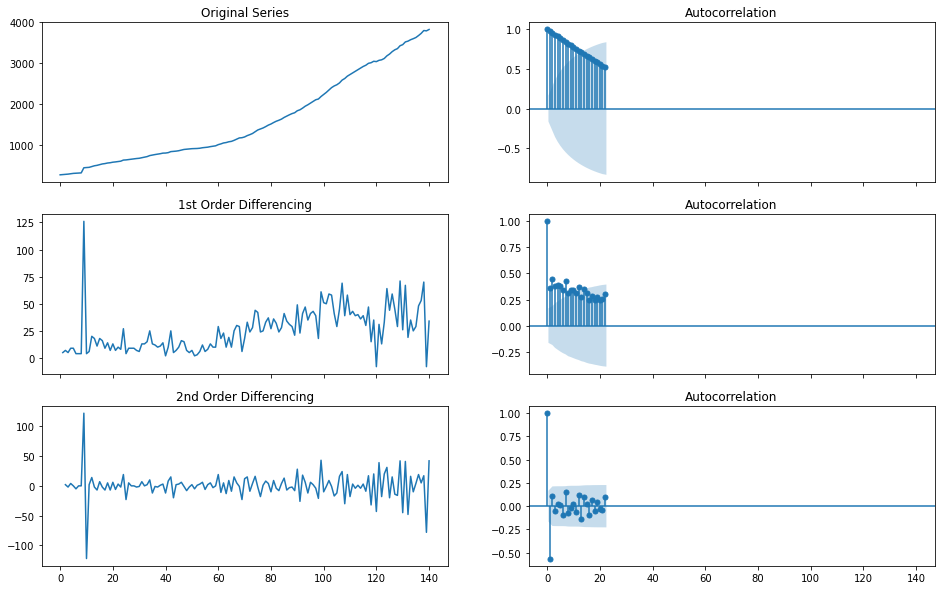

In [1038]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True, figsize = (16, 10))
axes[0, 0].plot(train_con.Confirmed); axes[0, 0].set_title('Original Series')
plot_acf(train_con.Confirmed, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train_con.Confirmed.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(train_con.Confirmed.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train_con.Confirmed.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train_con.Confirmed.diff().diff().dropna(), ax=axes[2, 1])
plt.show()

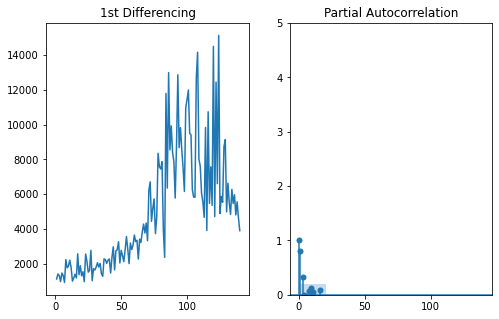

In [27]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize = (8, 5))
axes[0].plot(train_con_cali.Confirmed.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(df.value.diff().dropna(), ax=axes[1])

plt.show()

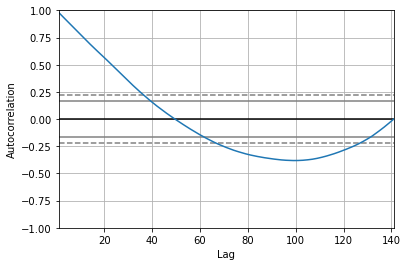

In [1039]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train_con.Confirmed)
plt.show()

In [1040]:
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
#for state in statenames:
#    train_data_con = train_data[['Confirmed']].loc[train_data[state] == 1].reset_index()
#    test_data_con = test_data[['Confirmed']].loc[test_data[state] == 1].reset_index()
#    autocorrelation_plot(train_data_con.Confirmed)
#    plt.show()

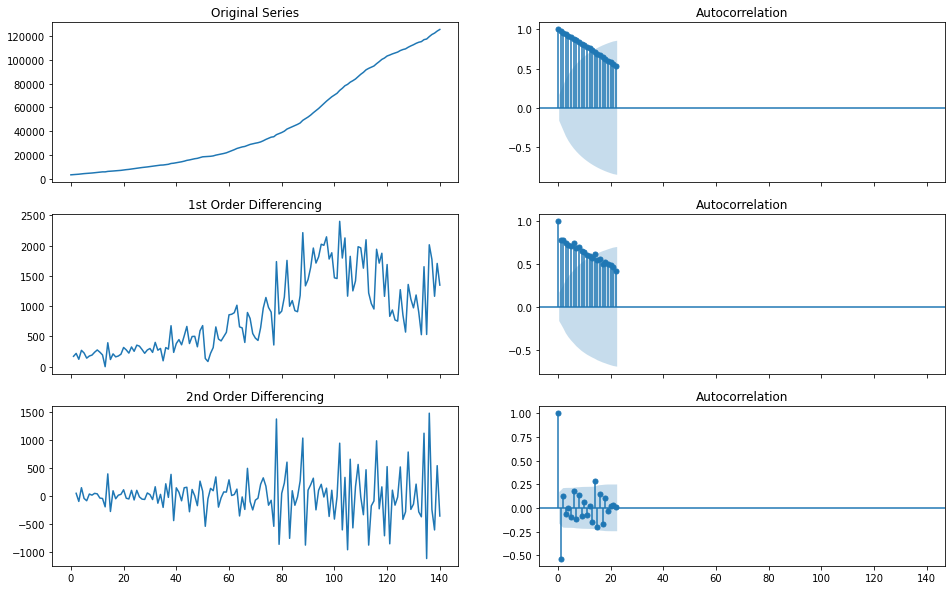

In [169]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

train_data_con = train_data[['Confirmed']].loc[train_data['Alabama'] == 1].reset_index()
test_data_con = test_data[['Confirmed']].loc[test_data['Alabama'] == 1].reset_index()
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True, figsize = (16, 10))
axes[0, 0].plot(train_data_con.Confirmed); axes[0, 0].set_title('Original Series')
plot_acf(train_data_con.Confirmed, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train_data_con.Confirmed.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(train_data_con.Confirmed.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train_data_con.Confirmed.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train_data_con.Confirmed.diff().diff().dropna(), ax=axes[2, 1])
plt.show()

## Auto ARIMA

In [21]:
train_con_cali = train[['Confirmed']].loc[train['California'] == 1].reset_index()
test_con_cali = test[['Confirmed']].loc[test['California'] == 1].reset_index()

In [25]:
from pmdarima import auto_arima
stepwise_model = auto_arima(train_con_cali.Confirmed, start_p=0, start_q=1,
                           max_p=10, max_q=3, m=12,
                           d=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
stepwise_model.order

Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=2602.724, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=2554.603, Time=0.17 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=2538.836, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=2536.843, Time=0.05 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=2538.836, Time=0.15 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=2538.705, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=2541.593, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=2553.276, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=inf, Time=0.19 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=2538.821, Time=0.13 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 1.378 seconds


(0, 2, 1)

In [18]:
from statsmodels.tsa.arima.model import ARIMA
history = [x for x in train_con_cali.Confirmed]
predictions = list()
for t in range(len(test_con_cali)):
    #model = ARIMA(history, order=(5,1,0))
    model = ARIMA(history, order = (0, 2, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_con_cali.Confirmed[t]
    history.append(yhat)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=711092.787003, expected=712475.000000
predicted=716234.853205, expected=715617.000000
predicted=721377.134960, expected=721281.000000
predicted=726519.582923, expected=726018.000000
predicted=731662.159421, expected=730662.000000
predicted=736804.835349, expected=735314.000000
predicted=741947.588113, expected=738856.000000
predicted=747090.400173, expected=740965.000000
predicted=752233.257936, expected=744344.000000
predicted=757376.150902, expected=747290.000000
predicted=762519.070983, expected=750961.000000
predicted=767662.011943, expected=754905.000000
predicted=772804.968990, expected=758933.000000
predicted=777947.938435, expected=761728.000000
predicted=783090.917434, expected=765134.000000
predicted=788233.903804, expected=768204.000000
predicted=793376.895860, expected=771321.000000
predicted=798519.892305, expected=775037.000000
predicted=803662.892137, expected=779491.000000
predicted=808805.894586, expected=783313.000000
predicted=813948.899058, expected=786168

In [27]:
np.rint(predictions)

array([711093., 716235., 721377., 726520., 731662., 736805., 741948.,
       747090., 752233., 757376., 762519., 767662., 772805., 777948.,
       783091., 788234., 793377., 798520., 803663., 808806., 813949.,
       819092., 824235., 829378., 834521., 839664.])

In [19]:
mape = np.absolute(predictions - test_con_cali.Confirmed) / test_con_cali.Confirmed
mape = np.sum(mape) / len(predictions) * 100
mape

2.033491494442372

## ARIMA models with no seasonality

In [13]:
import datetime
base = datetime.date(2020, 9, 1)
date_list = [base + datetime.timedelta(days=x) for x in range(26)]
for i in range(len(date_list)):
    date_list[i] = date_list[i].strftime("%m/%d/%Y")

In [23]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
numdays = 26
pred = pd.DataFrame(columns = ['Province_State', 'Date', 'Confirmed'])
for state in statenames:
    temp = pd.concat([pd.Series(np.repeat(state, repeats = numdays)), pd.Series(date_list)], axis = 1)
    train_con = train_data[['Confirmed']].loc[train_data[state] == 1]
    print(state)
    stepwise_model = auto_arima(train_con.Confirmed, start_p=0, start_q=1,
                           max_p=10, max_q=3, m=12,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    history = [x for x in train_con.Confirmed]
    predictions = list()
    for t in range(numdays):
        model = ARIMA(history, order = stepwise_model.order, step)
        model_fit = model.fit()
        output = model_fit.forecast()
        predictions.append(output[0])
        history.append(output[0])
    temp = pd.concat([temp, pd.Series(predictions)], axis = 1)
    temp.columns = ['Province_State', 'Date', 'Confirmed']
    pred = pred.append(temp)


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=2007.313, Time=0.40 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=2067.439, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=2022.503, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=2007.458, Time=0.11 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=2007.385, Time=0.11 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=2009.156, Time=0.98 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=2009.164, Time=1.01 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=2005.828, Time=0.03 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=2007.283, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=2007.365, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=2022.867, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=2003.776, Time=0.24 sec
 ARIMA(1,2,2)(1,0,0)[12]             : AIC=2003.131, Time=0.36 sec
 ARIMA(1,2,2)(2,0,0)[12]             : AIC=2005.023, Time=0.96 sec
 ARIMA(1,2,2)(1,0,1

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1224.896, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1233.001, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1232.983, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1223.338, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1221.706, Time=0.04 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1223.417, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1208.133, Time=0.06 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1209.740, Time=0.13 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1209.685, Time=0.14 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1211.526, Time=0.25 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1231.023, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=1205.562, Time=0.09 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=1206.808, Time=0.18 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=1206.693, Time=0.16 sec
 ARIMA(2,2,1)(1,0,1

 ARIMA(4,2,2)(0,0,1)[12]             : AIC=1752.136, Time=0.72 sec
 ARIMA(4,2,2)(0,0,0)[12]             : AIC=1750.591, Time=0.36 sec
 ARIMA(4,2,2)(1,0,0)[12]             : AIC=1752.261, Time=0.74 sec
 ARIMA(4,2,2)(1,0,1)[12]             : AIC=1754.122, Time=0.82 sec
 ARIMA(3,2,2)(0,0,0)[12]             : AIC=1776.904, Time=0.22 sec
 ARIMA(4,2,1)(0,0,0)[12]             : AIC=1769.253, Time=0.13 sec
 ARIMA(5,2,2)(0,0,0)[12]             : AIC=1751.737, Time=0.39 sec
 ARIMA(4,2,3)(0,0,0)[12]             : AIC=1754.264, Time=0.39 sec
 ARIMA(3,2,1)(0,0,0)[12]             : AIC=1781.196, Time=0.12 sec
 ARIMA(3,2,3)(0,0,0)[12]             : AIC=1778.552, Time=0.24 sec
 ARIMA(5,2,1)(0,0,0)[12]             : AIC=1767.567, Time=0.06 sec
 ARIMA(5,2,3)(0,0,0)[12]             : AIC=1759.407, Time=0.45 sec
 ARIMA(4,2,2)(0,0,0)[12] intercept   : AIC=1752.306, Time=0.40 sec

Best model:  ARIMA(4,2,2)(0,0,0)[12]          
Total fit time: 17.675 seconds


C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\bas

Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1922.860, Time=0.30 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=2006.042, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1945.982, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1922.274, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1920.296, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1922.264, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1917.176, Time=0.06 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1918.794, Time=0.13 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1918.927, Time=0.15 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1919.765, Time=0.26 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1944.551, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=1918.752, Time=0.11 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=1917.945, Time=0.13 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1917.662, Time=0.08 sec
 ARIMA(2,2,0)(0,0,0

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=2144.293, Time=0.27 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=2177.227, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=2164.771, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=2145.763, Time=0.11 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=2146.787, Time=0.09 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=2145.703, Time=0.85 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=2145.468, Time=0.53 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=2146.799, Time=0.03 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=2143.483, Time=0.31 sec
 ARIMA(0,2,0)(0,0,2)[12]             : AIC=2174.618, Time=0.28 sec
 ARIMA(1,2,1)(0,0,2)[12]             : AIC=2143.147, Time=0.50 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=2144.573, Time=0.16 sec
 ARIMA(1,2,1)(1,0,2)[12]             : AIC=2145.040, Time=0.84 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=2143.387, Time=0.52 sec
 ARIMA(1,2,0)(0,0,2

Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1929.726, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1961.890, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1956.315, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1931.743, Time=0.12 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1933.432, Time=0.10 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=1923.652, Time=0.47 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=1922.732, Time=0.29 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=1959.577, Time=0.23 sec
 ARIMA(1,2,1)(2,0,0)[12]             : AIC=1919.571, Time=0.53 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1926.529, Time=0.24 sec
 ARIMA(1,2,1)(2,0,1)[12]             : AIC=1920.588, Time=0.79 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1924.582, Time=0.27 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=1949.431, Time=0.24 sec
 ARIMA(2,2,1)(2,0,0)[12]             : AIC=1918.784, Time=0.66 sec
 ARIMA(2,2,1)(1,0,0

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\bas

Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1811.441, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1923.725, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1828.210, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1809.443, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1811.222, Time=0.04 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=1811.428, Time=0.45 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1809.710, Time=0.12 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1920.490, Time=0.08 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1787.601, Time=0.14 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1785.702, Time=0.05 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1787.628, Time=0.16 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.31 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1826.466, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[12]     

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1838.868, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1923.116, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1882.709, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1836.842, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1834.868, Time=0.04 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1836.838, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1834.799, Time=0.05 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1836.713, Time=0.17 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1836.724, Time=0.19 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1880.993, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=1835.553, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=1828.543, Time=0.16 sec
 ARIMA(1,2,2)(1,0,0)[12]             : AIC=1830.477, Time=0.42 sec
 ARIMA(1,2,2)(0,0,1)[12]

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=2232.123, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=2298.920, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=2255.924, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=2230.836, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=2228.559, Time=0.04 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=2230.141, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=2230.238, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=2230.063, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=2253.836, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=2229.006, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=2230.379, Time=0.10 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 0.753 seconds


C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1122.728, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1160.247, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1134.817, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1120.875, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1122.810, Time=0.02 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=1122.124, Time=0.19 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1120.802, Time=0.06 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=1122.515, Time=0.18 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=inf, Time=0.76 sec
 ARIMA(0,2,0)(1,0,0)[12]             : AIC=1158.328, Time=0.04 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1116.694, Time=0.16 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1118.392, Time=0.05 sec
 ARIMA(1,2,1)(2,0,0)[12]             : AIC=1118.548, Time=0.32 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1118.655, Time=0.23 sec
 ARIMA(1,2,1)(0,0,1)[12]

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\bas

Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1922.013, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1900.720, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1881.534, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1879.591, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1881.547, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1879.389, Time=0.05 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1881.332, Time=0.12 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1881.319, Time=0.18 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1899.165, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=1881.387, Time=0.10 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=1881.392, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1879.604, Time=0.02 sec
 ARIMA(2,2,0)(0,0,0)[12]     

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: Convergen

Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1955.723, Time=0.27 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1992.684, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1984.022, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1953.942, Time=0.10 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1953.878, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1954.171, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1950.871, Time=0.07 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1952.270, Time=0.20 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1952.209, Time=0.16 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1954.088, Time=0.29 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1983.404, Time=0.01 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=1947.970, Time=0.09 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=1949.871, Time=0.23 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=1949.863, Time=0.19 sec
 ARIMA(2,2,1)(1,0,1

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarnin

Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1740.729, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1714.266, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1692.809, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1690.809, Time=0.04 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1692.809, Time=0.11 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1691.672, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1691.816, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1712.270, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=1693.624, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=1692.288, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 0.891 seconds
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1852.660, Time=0.32 sec
 ARIMA(0,2,0)(0,0,0)[12]             

 ARIMA(0,2,0)(0,0,1)[12] intercept   : AIC=2369.672, Time=0.09 sec

Best model:  ARIMA(0,2,0)(0,0,1)[12]          
Total fit time: 2.983 seconds
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=2029.138, Time=0.37 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=2098.312, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=2054.925, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=2028.065, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=2027.517, Time=0.04 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=2028.358, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=2029.010, Time=0.06 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=2029.044, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=2054.004, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=2030.614, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=2027.088, Time=0.08 sec
 ARIMA(0,2,1)(1,0,0)[12] intercept   : AIC=2028.121, Time=0.23 sec
 ARIMA(0

 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1634.700, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1634.928, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1633.659, Time=0.10 sec
 ARIMA(0,2,2)(1,0,0)[12]             : AIC=1634.317, Time=0.23 sec
 ARIMA(0,2,2)(0,0,1)[12]             : AIC=1634.526, Time=0.26 sec
 ARIMA(0,2,2)(1,0,1)[12]             : AIC=inf, Time=0.46 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=1638.318, Time=0.07 sec
 ARIMA(0,2,3)(0,0,0)[12]             : AIC=1625.560, Time=0.08 sec
 ARIMA(0,2,3)(1,0,0)[12]             : AIC=1626.584, Time=0.18 sec
 ARIMA(0,2,3)(0,0,1)[12]             : AIC=1626.709, Time=0.21 sec
 ARIMA(0,2,3)(1,0,1)[12]             : AIC=1628.450, Time=0.36 sec
 ARIMA(1,2,3)(0,0,0)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,2,3)(0,0,0)[12] intercept   : AIC=1626.198, Time=0.17 sec

Best model:  ARIMA(0,2,3)(0,0,0)[12]          
Total fit time: 2.863 seconds


C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1977.604, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1964.667, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1929.919, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1927.977, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1929.939, Time=0.09 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1927.887, Time=0.06 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1929.820, Time=0.15 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1929.788, Time=0.13 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1963.094, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=1924.174, Time=0.08 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=1925.472, Time=0.18 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=1925.097, Time=0.18 sec
 ARIMA(2,2,1)(1,0,1)[12]     

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarnin

Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1920.040, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1969.297, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1927.256, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1920.366, Time=0.14 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1921.252, Time=0.09 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=1921.967, Time=0.55 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=1921.949, Time=0.62 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1921.513, Time=0.03 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=1920.168, Time=0.33 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=1920.786, Time=0.25 sec
 ARIMA(0,2,1)(2,0,2)[12]             : AIC=inf, Time=0.85 sec
 ARIMA(0,2,0)(1,0,1)[12]             : AIC=1967.410, Time=0.36 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1920.692, Time=0.27 sec
 ARIMA(0,2,2)(1,0,1)[12]             : AIC=1921.038, Time=0.28 sec
 ARIMA(1,2,0)(1,0,1)[12]

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1687.039, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1707.780, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1701.194, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1687.261, Time=0.08 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1687.334, Time=0.07 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=1682.425, Time=0.42 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=1681.041, Time=0.27 sec
 ARIMA(0,2,0)(2,0,0)[12]             : AIC=1710.343, Time=0.14 sec
 ARIMA(1,2,1)(2,0,0)[12]             : AIC=1678.082, Time=0.38 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1678.842, Time=0.14 sec
 ARIMA(1,2,1)(2,0,1)[12]             : AIC=1679.890, Time=0.57 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1679.754, Time=0.18 sec
 ARIMA(1,2,0)(2,0,0)[12]             : AIC=1700.092, Time=0.23 sec
 ARIMA(2,2,1)(2,0,0)[12]             : AIC=1679.099, Time=0.45 sec
 ARIMA(1,2,2)(2,0,0

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarnin

Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=880.865, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=959.654, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=909.432, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=880.307, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=878.318, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=880.309, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=879.111, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=879.364, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=907.437, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=881.020, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=880.285, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 0.645 seconds
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1914.791, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1393.647, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1470.592, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1419.927, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1393.186, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1395.093, Time=0.02 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=1388.715, Time=0.29 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=1387.468, Time=0.44 sec
 ARIMA(0,2,1)(2,0,2)[12]             : AIC=1387.373, Time=0.54 sec
 ARIMA(0,2,1)(2,0,1)[12]             : AIC=1385.447, Time=0.45 sec
 ARIMA(0,2,1)(2,0,0)[12]             : AIC=1386.626, Time=0.21 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1394.978, Time=0.08 sec
 ARIMA(0,2,0)(2,0,1)[12]             : AIC=1458.883, Time=0.35 sec
 ARIMA(1,2,1)(2,0,1)[12]             : AIC=1385.626, Time=0.49 sec
 ARIMA(0,2,2)(2,0,1)[12]             : AIC=1385.725, Time=0.47 sec
 ARIMA(1,2,0)(2,0,1

In [58]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
numdays = 26
pred_death = pd.DataFrame(columns = ['Province_State', 'Date', 'Deaths'])
for state in statenames:
    temp = pd.concat([pd.Series(np.repeat(state, repeats = numdays)), pd.Series(date_list)], axis = 1)
    train_death = train_data[['Deaths']].loc[train_data[state] == 1]
    print(state)
    stepwise_model = auto_arima(train_death.Deaths, start_p=0, start_q=1,
                           max_p=10, max_q=3, m=12,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    history = [x for x in train_death.Deaths]
    predictions = list()
    for t in range(numdays):
        if (state == 'New York'):
            model = ARIMA(history, order = (1,2,2))
        else:
            model = ARIMA(history, order = stepwise_model.order)
        model_fit = model.fit()
        output = model_fit.forecast()
        predictions.append(output[0])
        history.append(output[0])
    temp = pd.concat([temp, pd.Series(predictions)], axis = 1)
    temp.columns = ['Province_State', 'Date', 'Deaths']
    pred_death = pred_death.append(temp)


Alabama
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1082.416, Time=0.27 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1129.263, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1119.518, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1080.565, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1078.932, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1080.638, Time=0.08 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1074.240, Time=0.04 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1076.239, Time=0.17 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1076.238, Time=0.17 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1078.225, Time=0.36 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1117.569, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=1073.827, Time=0.07 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=1075.822, Time=0.18 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=1075.821, Time=0.19 sec
 ARIMA(2,2,

 ARIMA(1,2,2)(2,0,1)[12]             : AIC=1444.252, Time=0.95 sec
 ARIMA(1,2,2)(1,0,1)[12]             : AIC=1459.177, Time=0.56 sec
 ARIMA(2,2,2)(2,0,0)[12]             : AIC=1443.383, Time=1.04 sec
 ARIMA(1,2,3)(2,0,0)[12]             : AIC=1441.302, Time=0.94 sec
 ARIMA(1,2,3)(1,0,0)[12]             : AIC=1448.704, Time=0.29 sec
 ARIMA(1,2,3)(2,0,1)[12]             : AIC=1443.052, Time=1.21 sec
 ARIMA(1,2,3)(1,0,1)[12]             : AIC=1447.488, Time=0.42 sec
 ARIMA(0,2,3)(2,0,0)[12]             : AIC=1449.887, Time=0.43 sec
 ARIMA(2,2,3)(2,0,0)[12]             : AIC=inf, Time=1.51 sec
 ARIMA(1,2,3)(2,0,0)[12] intercept   : AIC=1441.204, Time=1.20 sec
 ARIMA(1,2,3)(1,0,0)[12] intercept   : AIC=1449.364, Time=0.37 sec
 ARIMA(1,2,3)(2,0,1)[12] intercept   : AIC=1443.044, Time=1.50 sec
 ARIMA(1,2,3)(1,0,1)[12] intercept   : AIC=1447.479, Time=0.75 sec
 ARIMA(0,2,3)(2,0,0)[12] intercept   : AIC=1449.920, Time=0.73 sec
 ARIMA(1,2,2)(2,0,0)[12] intercept   : AIC=1441.985, Time=1.05 sec


C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Colorado
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1133.769, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1199.298, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1171.961, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1132.171, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1131.618, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1132.336, Time=0.06 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1132.616, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1132.608, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1170.003, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=1132.842, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=1131.116, Time=0.06 sec
 ARIMA(0,2,1)(1,0,0)[12] intercept   : AIC=1131.746, Time=0.18 sec
 ARIMA(0,2,1)(0,0,1)[12] intercept   : AIC=1131.553, Time=0.15 sec
 ARIMA(0,2,1)(1,0,1)[12] intercept   : AIC=1133.210, Time=0.31 sec
 ARIMA(0,2

 ARIMA(0,2,1)(1,0,2)[12]             : AIC=inf, Time=0.97 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=698.716, Time=0.03 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=650.876, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=657.931, Time=0.03 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=652.872, Time=0.14 sec
 ARIMA(1,2,1)(0,0,2)[12]             : AIC=652.869, Time=0.29 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=652.108, Time=0.10 sec
 ARIMA(1,2,1)(1,0,2)[12]             : AIC=inf, Time=0.89 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=688.302, Time=0.08 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=646.316, Time=0.14 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=651.474, Time=0.05 sec
 ARIMA(2,2,1)(1,0,1)[12]             : AIC=648.158, Time=0.21 sec
 ARIMA(2,2,1)(0,0,2)[12]             : AIC=647.953, Time=0.37 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=648.007, Time=0.12 sec
 ARIMA(2,2,1)(1,0,2)[12]             : AIC=inf, Time=1.18 sec
 ARIMA(2,2,0)(0,0,1)[1

 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1241.729, Time=0.13 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1243.693, Time=0.22 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1288.571, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=1233.054, Time=0.12 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=1234.767, Time=0.20 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=1234.742, Time=0.17 sec
 ARIMA(2,2,1)(1,0,1)[12]             : AIC=1236.635, Time=0.39 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=1273.609, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[12]             : AIC=1232.912, Time=0.09 sec
 ARIMA(3,2,1)(1,0,0)[12]             : AIC=1234.773, Time=0.25 sec
 ARIMA(3,2,1)(0,0,1)[12]             : AIC=1234.767, Time=0.22 sec
 ARIMA(3,2,1)(1,0,1)[12]             : AIC=1236.746, Time=0.45 sec
 ARIMA(3,2,0)(0,0,0)[12]             : AIC=1274.666, Time=0.06 sec
 ARIMA(4,2,1)(0,0,0)[12]             : AIC=1200.663, Time=0.12 sec
 ARIMA(4,2,1)(1,0,0)[12]             : AIC=1201.620, Time=0.24

 ARIMA(5,2,2)(0,0,0)[12]             : AIC=1267.876, Time=0.22 sec
 ARIMA(5,2,2)(1,0,0)[12]             : AIC=1269.848, Time=0.45 sec
 ARIMA(5,2,2)(0,0,1)[12]             : AIC=1269.841, Time=0.32 sec
 ARIMA(5,2,2)(1,0,1)[12]             : AIC=inf, Time=0.99 sec
 ARIMA(6,2,2)(0,0,0)[12]             : AIC=1262.231, Time=0.24 sec
 ARIMA(6,2,2)(1,0,0)[12]             : AIC=1264.186, Time=0.58 sec
 ARIMA(6,2,2)(0,0,1)[12]             : AIC=1264.181, Time=0.43 sec
 ARIMA(6,2,2)(1,0,1)[12]             : AIC=1266.090, Time=0.91 sec
 ARIMA(6,2,1)(0,0,0)[12]             : AIC=1263.810, Time=0.18 sec
 ARIMA(7,2,2)(0,0,0)[12]             : AIC=1264.063, Time=0.46 sec
 ARIMA(6,2,3)(0,0,0)[12]             : AIC=1260.670, Time=0.43 sec
 ARIMA(6,2,3)(1,0,0)[12]             : AIC=1262.591, Time=1.03 sec
 ARIMA(6,2,3)(0,0,1)[12]             : AIC=1262.577, Time=0.79 sec
 ARIMA(6,2,3)(1,0,1)[12]             : AIC=1264.258, Time=1.11 sec
 ARIMA(5,2,3)(0,0,0)[12]             : AIC=1266.767, Time=0.30 sec


C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Maine
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=412.506, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=491.809, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=465.112, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=410.732, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=408.768, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=410.738, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=410.499, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=410.298, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=463.130, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=410.348, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=407.994, Time=0.09 sec
 ARIMA(0,2,1)(1,0,0)[12] intercept   : AIC=409.993, Time=0.21 sec
 ARIMA(0,2,1)(0,0,1)[12] intercept   : AIC=409.992, Time=0.18 sec
 ARIMA(0,2,1)(1,0,1)[12] intercept   : AIC=411.714, Time=0.38 sec
 ARIMA(0,2,0)(0,0,0)[12] in

Mississippi
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1079.515, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1129.437, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1116.812, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1077.632, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1079.042, Time=0.02 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=1079.291, Time=0.27 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1078.272, Time=0.07 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(0,2,0)(0,0,1)[12]             : AIC=1126.808, Time=0.08 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=1074.120, Time=0.13 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1075.296, Time=0.06 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=1076.102, Time=0.21 sec
 ARIMA(1,2,1)(0,0,2)[12]             : AIC=1076.068, Time=0.34 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=1074.481, Time=0.12 sec
 ARIMA(1,2,1

 ARIMA(1,2,2)(0,0,0)[12]             : AIC=1822.317, Time=0.14 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.10 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 1.035 seconds
New Mexico
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.26 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=779.013, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=744.870, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=699.329, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=697.345, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=699.334, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=698.960, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=698.875, Time=0.03 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=743.069, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=701.345, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=699.262, Time=0.04 sec

Best model:  ARI

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarnin

North Carolina
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1095.758, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1174.986, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1141.323, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1093.785, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1092.012, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1093.797, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1094.009, Time=0.07 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1094.009, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=1140.035, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=1096.006, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=1092.973, Time=0.06 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 0.657 seconds
North Dakota
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.39 sec
 ARIMA(0,

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Oklahoma
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=790.762, Time=0.13 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=840.978, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=828.323, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=790.645, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=797.891, Time=0.03 sec
 ARIMA(0,2,1)(0,0,2)[12]             : AIC=788.605, Time=0.28 sec
 ARIMA(0,2,1)(1,0,2)[12]             : AIC=788.803, Time=0.32 sec
 ARIMA(0,2,0)(0,0,2)[12]             : AIC=831.254, Time=0.15 sec
 ARIMA(1,2,1)(0,0,2)[12]             : AIC=785.192, Time=0.30 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=786.189, Time=0.14 sec
 ARIMA(1,2,1)(1,0,2)[12]             : AIC=785.313, Time=0.44 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=786.569, Time=0.20 sec
 ARIMA(1,2,0)(0,0,2)[12]             : AIC=823.816, Time=0.24 sec
 ARIMA(2,2,1)(0,0,2)[12]             : AIC=778.456, Time=0.34 sec
 ARIMA(2,2,1)(0,0,1)[12]

 ARIMA(1,2,1)(0,0,0)[12]             : AIC=886.334, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=886.222, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=933.031, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[12]             : AIC=886.465, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[12] intercept   : AIC=884.620, Time=0.05 sec

Best model:  ARIMA(0,2,1)(0,0,0)[12]          
Total fit time: 0.640 seconds
South Carolina
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=1124.925, Time=0.16 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=1189.640, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=1164.489, Time=0.06 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=1122.995, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=1121.093, Time=0.03 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=1123.007, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=1123.072, Time=0.03 sec
 ARIMA(0,2,2)(0,0,0)[12]             : AIC=1123.066, Time=0.09 se

 ARIMA(1,2,0)(1,0,0)[12]             : AIC=268.170, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=242.247, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[12]             : AIC=241.160, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[12]             : AIC=242.240, Time=0.05 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=240.376, Time=0.04 sec
 ARIMA(1,2,1)(1,0,0)[12]             : AIC=242.344, Time=0.13 sec
 ARIMA(1,2,1)(0,0,1)[12]             : AIC=242.343, Time=0.13 sec
 ARIMA(1,2,1)(1,0,1)[12]             : AIC=244.342, Time=0.15 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=266.186, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=240.137, Time=0.05 sec
 ARIMA(2,2,1)(1,0,0)[12]             : AIC=242.127, Time=0.13 sec
 ARIMA(2,2,1)(0,0,1)[12]             : AIC=242.127, Time=0.16 sec
 ARIMA(2,2,1)(1,0,1)[12]             : AIC=244.127, Time=0.17 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=264.600, Time=0.02 sec
 ARIMA(3,2,1)(0,0,0)[12]             : AIC=234.632, Time=0.07 sec
 ARIMA(3,2

 ARIMA(1,2,0)(1,0,1)[12]             : AIC=334.800, Time=0.18 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=325.754, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=327.326, Time=0.06 sec
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=327.298, Time=0.07 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=328.734, Time=0.28 sec
 ARIMA(3,2,0)(0,0,0)[12]             : AIC=325.979, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(3,2,1)(0,0,0)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(2,2,0)(0,0,0)[12] intercept   : AIC=327.741, Time=0.04 sec

Best model:  ARIMA(2,2,0)(0,0,0)[12]          
Total fit time: 2.266 seconds


In [63]:
from pmdarima import auto_arima
stepwise_model = auto_arima(train_data[['Deaths']].loc[train_data['Wyoming'] == 1], start_p=0, start_q=1,
                           max_p=10, max_q=3, m=12,
                           d=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
stepwise_model.order

Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[12]             : AIC=inf, Time=0.40 sec
 ARIMA(0,2,0)(0,0,0)[12]             : AIC=392.406, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[12]             : AIC=333.562, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,2,0)(0,0,0)[12]             : AIC=332.238, Time=0.01 sec
 ARIMA(1,2,0)(0,0,1)[12]             : AIC=333.448, Time=0.04 sec
 ARIMA(1,2,0)(1,0,1)[12]             : AIC=334.800, Time=0.15 sec
 ARIMA(2,2,0)(0,0,0)[12]             : AIC=325.754, Time=0.03 sec
 ARIMA(2,2,0)(1,0,0)[12]             : AIC=327.326, Time=0.05 sec
 ARIMA(2,2,0)(0,0,1)[12]             : AIC=327.298, Time=0.07 sec
 ARIMA(2,2,0)(1,0,1)[12]             : AIC=328.734, Time=0.28 sec
 ARIMA(3,2,0)(0,0,0)[12]             : AIC=325.979, Time=0.03 sec
 ARIMA(2,2,1)(0,0,0)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(1,2,1)(0,0,0)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(3,2,1)(0,0,0)[12]             : AIC=inf, T

(2, 2, 0)

In [64]:
history = [x for x in train_data.Deaths.loc[train_data['Wyoming'] == 1]]
predictions = list()
for t in range(numdays):
    model = ARIMA(history, order = (2,2,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    predictions.append(output[0])
    history.append(output[0])

In [97]:
actual = test_data.sort_values(by = ['Province_State', 'Last_Update'])
actual = actual['Confirmed']
mape = np.absolute(np.array(pred['Confirmed']) - np.array(actual)) / np.array(actual)
mape = np.sum(mape, axis = 0) / len(pred)
mape

0.023013793097609897

In [92]:
pred2 = pred
pred2['Deaths'] = pred_death['Deaths']
pred2 = pred2.sort_values(by = ['Date', 'Province_State']).reset_index(drop = True)
pred2 = pred2.drop(columns = ['Province_State', 'Date'])
pred2.index.name = 'ForecastID'

In [103]:
actual = test_data[['Confirmed', 'Deaths']]
mape = np.absolute(np.array(pred2[['Confirmed', 'Deaths']]) - actual) / np.array(actual)
mape = np.sum(mape, axis = 0) / len(pred2)
#mape = np.sum(mape) / (2 * len(pred2))
mape

Confirmed    0.023014
Deaths       0.029154
dtype: float64

In [93]:
pred2.to_csv("Team1_AutoARIMA.csv")

In [153]:
pred3 = pred
pred3['Deaths'] = pred_death['Deaths']
pred3 = pred3.sort_values(by = ['Date', 'Province_State']).reset_index(drop = True)

actual = test_data[['Confirmed', 'Deaths']].reset_index(drop = True)
pred3['mapeConfirm'] = np.absolute(pred3[['Confirmed']] - actual[['Confirmed']]) / actual[['Confirmed']] * 100
pred3['mapeDeaths'] = np.absolute(pred3[['Deaths']] - actual[['Deaths']]) / actual[['Deaths']] * 100

pred3.groupby(by = 'Province_State').mean()

,Confirmed,Deaths,mapeConfirm,mapeDeaths
Province_State,,,,
Alabama,144131.423700,2435.656163,0.043169,0.038257
Alaska,6117.748628,43.466424,0.015845,0.029751
Arizona,207224.884269,5588.840146,0.008475,0.050327
Arkansas,69261.280070,960.667914,0.013353,0.057927
California,775376.986221,14461.533127,0.020335,0.011651
Colorado,60863.759647,1990.733179,0.014158,0.001215
Connecticut,53676.116661,4473.605240,0.016304,0.001801
Delaware,18379.737755,622.231396,0.019553,0.010712
Florida,657496.196314,12485.328480,0.007333,0.006976


## ARIMA with seasonality m = 7

In [89]:
import datetime
base = datetime.date(2020, 9, 1)
date_list = [base + datetime.timedelta(days=x) for x in range(26)]
for i in range(len(date_list)):
    date_list[i] = date_list[i].strftime("%m/%d/%Y")

In [100]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
numdays = 26
seasonpred = pd.DataFrame(columns = ['Province_State', 'Date', 'Confirmed'])
for state in statenames:
    temp = pd.concat([pd.Series(np.repeat(state, repeats = numdays)), pd.Series(date_list)], axis = 1)
    train_con = train_data[['Confirmed']].loc[train_data[state] == 1]
    print(state)
    stepwise_model = auto_arima(train_con.Confirmed, start_p=0, start_q=1,
                           max_p=10, max_q=3, m=7,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    history = [x for x in train_con.Confirmed]
    predictions = list()
    for t in range(numdays):
        if (state == "Pennsylvania"):
            model = ARIMA(history, order = (3,2,2), seasonal_order = stepwise_model.seasonal_order)
        else:
            model = ARIMA(history, order = stepwise_model.order, seasonal_order = stepwise_model.seasonal_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        predictions.append(output[0])
        history.append(output[0])
    temp = pd.concat([temp, pd.Series(predictions)], axis = 1)
    temp.columns = ['Province_State', 'Date', 'Confirmed']
    seasonpred = seasonpred.append(temp)


Alabama
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=2007.032, Time=0.39 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=2067.439, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=2024.723, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=2007.708, Time=0.13 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=2007.640, Time=0.13 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=2001.541, Time=0.41 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=1999.836, Time=0.20 sec
 ARIMA(0,2,0)(2,0,0)[7]             : AIC=2053.765, Time=0.16 sec
 ARIMA(1,2,1)(2,0,0)[7]             : AIC=2001.578, Time=0.29 sec
 ARIMA(0,2,2)(2,0,0)[7]             : AIC=2001.623, Time=0.27 sec
 ARIMA(1,2,0)(2,0,0)[7]             : AIC=2015.719, Time=0.22 sec
 ARIMA(1,2,2)(2,0,0)[7]             : AIC=inf, Time=0.63 sec
 ARIMA(0,2,1)(2,0,0)[7] intercept   : AIC=2001.132, Time=0.49 sec

Best model:  ARIMA(0,2,1)(2,0,0)[7]          
Total fit time: 3.409 seconds
Alaska
Performing s

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Arizona
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=2162.162, Time=0.32 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=2250.889, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=2204.587, Time=0.13 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=2179.463, Time=0.18 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=2169.314, Time=0.16 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=2163.994, Time=0.49 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=2163.969, Time=0.62 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=2195.371, Time=0.07 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=2172.219, Time=0.31 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=2163.922, Time=0.24 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=inf, Time=0.92 sec
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=2225.128, Time=0.24 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=2163.712, Time=0.37 sec
 ARIMA(0,2,2)(1,0,1)[7]             : AIC=2163.494, Time=0.34 sec
 ARIMA(1,2,0)(1,0,1)[7]       

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarnin

Arkansas
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1820.596, Time=0.42 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1885.024, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1847.967, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1822.705, Time=0.12 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1822.061, Time=0.11 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=inf, Time=0.42 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=inf, Time=0.43 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=1823.756, Time=0.05 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=1823.404, Time=0.24 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=1822.524, Time=0.23 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=inf, Time=0.63 sec
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=1886.119, Time=0.17 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=1822.370, Time=0.45 sec
 ARIMA(0,2,2)(1,0,1)[7]             : AIC=1822.412, Time=0.58 sec
 ARIMA(1,2,0)(1,0,1)[7]             : A

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarnin

Delaware
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1616.505, Time=0.28 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1701.857, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1660.565, Time=0.11 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1614.528, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=1613.087, Time=0.07 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1614.568, Time=0.14 sec
 ARIMA(1,2,1)(0,0,0)[7]             : AIC=1613.903, Time=0.11 sec
 ARIMA(0,2,2)(0,0,0)[7]             : AIC=1613.728, Time=0.11 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=1659.592, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[7]             : AIC=1615.094, Time=0.18 sec
 ARIMA(0,2,1)(0,0,0)[7] intercept   : AIC=1614.239, Time=0.09 sec

Best model:  ARIMA(0,2,1)(0,0,0)[7]          
Total fit time: 1.322 seconds
Florida
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=2382.952, Time=0.41 sec
 ARIMA(0,2,0)(0,0,0)[7]     

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: Convergen

Georgia
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=2125.711, Time=0.34 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=2177.227, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=2165.099, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=2142.554, Time=0.15 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=2138.636, Time=0.12 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=2123.292, Time=0.49 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=2125.930, Time=0.23 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=2123.333, Time=1.00 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=2122.314, Time=0.52 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=2134.173, Time=0.36 sec
 ARIMA(0,2,0)(1,0,2)[7]             : AIC=2165.500, Time=0.47 sec
 ARIMA(1,2,1)(1,0,2)[7]             : AIC=2124.207, Time=0.64 sec
 ARIMA(0,2,2)(1,0,2)[7]             : AIC=2124.147, Time=0.95 sec
 ARIMA(1,2,0)(1,0,2)[7]             : AIC=2145.404, Time=0.49 sec
 ARIMA(1,2,2)(1,0,2)[7]  

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarnin

Hawaii
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1333.471, Time=0.25 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1381.355, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1364.789, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1348.273, Time=0.10 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1342.126, Time=0.10 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=1334.038, Time=0.36 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=1334.111, Time=0.44 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=1354.975, Time=0.05 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=1338.473, Time=0.24 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=1332.951, Time=0.18 sec
 ARIMA(0,2,0)(2,0,0)[7]             : AIC=1373.675, Time=0.11 sec
 ARIMA(1,2,1)(2,0,0)[7]             : AIC=1333.612, Time=0.25 sec
 ARIMA(0,2,2)(2,0,0)[7]             : AIC=1333.251, Time=0.22 sec
 ARIMA(1,2,0)(2,0,0)[7]             : AIC=1357.728, Time=0.18 sec
 ARIMA(1,2,2)(2,0,0)[7]   

 ARIMA(1,2,2)(0,0,1)[7]             : AIC=1917.210, Time=0.28 sec
 ARIMA(3,2,2)(0,0,1)[7]             : AIC=1909.264, Time=0.65 sec
 ARIMA(2,2,3)(0,0,1)[7] intercept   : AIC=1907.392, Time=0.82 sec

Best model:  ARIMA(2,2,3)(0,0,1)[7]          
Total fit time: 28.268 seconds


C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: Convergen

Kansas
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1728.678, Time=0.41 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1923.725, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1774.303, Time=0.12 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1771.454, Time=0.19 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1741.765, Time=0.26 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=1730.320, Time=0.87 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=1730.367, Time=0.85 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=1811.222, Time=0.08 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=1752.177, Time=0.40 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=1734.170, Time=0.30 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=inf, Time=0.65 sec
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=1824.888, Time=0.22 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=1715.733, Time=0.64 sec
 ARIMA(1,2,1)(0,0,1)[7]             : AIC=1752.698, Time=0.23 sec
 ARIMA(1,2,1)(1,0,0)[7]        

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Kentucky
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1824.527, Time=0.42 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1923.116, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1874.933, Time=0.12 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1827.492, Time=0.17 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1825.479, Time=0.17 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=inf, Time=0.54 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=inf, Time=0.52 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=1834.868, Time=0.07 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=1828.141, Time=0.31 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=1826.047, Time=0.28 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=inf, Time=0.80 sec
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=1919.995, Time=0.23 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=1823.084, Time=0.43 sec
 ARIMA(1,2,1)(0,0,1)[7]             : AIC=1827.204, Time=0.19 sec
 ARIMA(1,2,1)(1,0,0)[7]             : A

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Louisiana
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=2203.088, Time=0.34 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=2298.920, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=2233.242, Time=0.13 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=2209.077, Time=0.17 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=2204.376, Time=0.14 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=2204.757, Time=0.42 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=2204.592, Time=0.49 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=2228.559, Time=0.07 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=2208.507, Time=0.32 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=2204.803, Time=0.25 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=2206.841, Time=0.95 sec
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=2269.556, Time=0.09 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=2205.088, Time=0.37 sec
 ARIMA(0,2,2)(1,0,1)[7]             : AIC=2205.088, Time=0.36 sec
 ARIMA(1,2,0)(1,0,1)[7]

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Maine
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1106.088, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1160.247, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1116.554, Time=0.09 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1115.391, Time=0.08 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1111.789, Time=0.08 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=1107.720, Time=0.32 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=1107.747, Time=0.39 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=1122.810, Time=0.03 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=1112.882, Time=0.20 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=1109.712, Time=0.17 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=1109.695, Time=0.81 sec
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=1155.052, Time=0.18 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=1108.084, Time=0.30 sec
 ARIMA(0,2,2)(1,0,1)[7]             : AIC=1108.086, Time=0.29 sec
 ARIMA(1,2,0)(1,0,1)[7]    

 ARIMA(0,2,2)(2,0,2)[7]             : AIC=1769.031, Time=0.98 sec
 ARIMA(0,2,3)(1,0,1)[7]             : AIC=1767.677, Time=0.40 sec
 ARIMA(1,2,3)(1,0,1)[7]             : AIC=1767.618, Time=0.63 sec
 ARIMA(0,2,2)(1,0,1)[7] intercept   : AIC=1766.891, Time=0.50 sec

Best model:  ARIMA(0,2,2)(1,0,1)[7]          
Total fit time: 12.972 seconds
Mississippi
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1941.362, Time=0.32 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1992.684, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1976.328, Time=0.11 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1946.751, Time=0.15 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1943.376, Time=0.14 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=1943.223, Time=0.53 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=1943.228, Time=0.53 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=1953.878, Time=0.06 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=1943.979, Time=0.27 sec
 ARIMA(0,

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Nebraska
Performing stepwise search to minimize aic
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=1701.121, Time=0.48 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1734.236, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1694.284, Time=0.31 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1702.651, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1961.309, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1709.990, Time=0.10 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=1696.279, Time=0.61 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=1696.280, Time=0.49 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=1696.997, Time=0.27 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=1698.149, Time=0.59 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=1704.189, Time=0.15 sec
 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=1683.873, Time=0.42 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=1705.568, Time=0.11 sec
 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=1685.560, Time=0.87 sec
 ARIMA(2,1,0)(1,0,1)[7] 

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarnin

New Mexico
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=inf, Time=0.44 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1604.040, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1554.478, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1534.940, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=1533.163, Time=0.04 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1534.900, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[7]             : AIC=1533.179, Time=0.08 sec
 ARIMA(0,2,2)(0,0,0)[7]             : AIC=1533.442, Time=0.07 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=1552.507, Time=0.04 sec
 ARIMA(1,2,2)(0,0,0)[7]             : AIC=1534.957, Time=0.12 sec
 ARIMA(0,2,1)(0,0,0)[7] intercept   : AIC=1535.082, Time=0.09 sec

Best model:  ARIMA(0,2,1)(0,0,0)[7]          
Total fit time: 1.133 seconds
New York
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=2372.319, Time=0.50 sec
 ARIMA(0,2,0)(0,0,0)[7]       

 ARIMA(1,2,2)(1,0,1)[7]             : AIC=1938.291, Time=0.43 sec
 ARIMA(0,2,1)(1,0,1)[7] intercept   : AIC=1936.596, Time=0.41 sec

Best model:  ARIMA(0,2,1)(1,0,1)[7]          
Total fit time: 4.927 seconds
Oklahoma
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1824.970, Time=0.29 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1870.808, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1860.761, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1840.623, Time=0.13 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1839.128, Time=0.11 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=1820.286, Time=0.39 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=1825.883, Time=0.19 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=1821.824, Time=0.54 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=1819.862, Time=0.49 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=1831.359, Time=0.31 sec
 ARIMA(0,2,0)(1,0,2)[7]             : AIC=1847.444, Time=0.50 sec
 ARIMA(1,2,1)

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Rhode Island
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1619.647, Time=0.21 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1734.059, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1670.229, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1633.910, Time=0.15 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1620.917, Time=0.12 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=1621.645, Time=0.35 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=1621.644, Time=0.33 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=1655.787, Time=0.05 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=1629.542, Time=0.29 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=1620.257, Time=0.24 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=1623.629, Time=0.57 sec
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=1710.398, Time=0.13 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=1617.014, Time=0.26 sec
 ARIMA(1,2,1)(0,0,1)[7]             : AIC=1634.685, Time=0.20 sec
 ARIMA(1,2,1)(1,0,0)

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarnin

South Carolina
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1914.128, Time=0.33 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1969.297, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1929.400, Time=0.11 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1918.822, Time=0.14 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1916.864, Time=0.13 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=1915.802, Time=0.49 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=1915.902, Time=0.55 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=1921.513, Time=0.06 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=1916.093, Time=0.29 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=1914.438, Time=0.25 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=inf, Time=0.96 sec
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=inf, Time=0.21 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=1912.922, Time=0.40 sec
 ARIMA(1,2,1)(0,0,1)[7]             : AIC=1920.162, Time=0.23 sec
 ARIMA(1,2,1)(1,0,0)[7]     

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarnin

Utah
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1649.311, Time=0.41 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1707.780, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1699.031, Time=0.11 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1679.157, Time=0.12 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1672.738, Time=0.12 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=1644.666, Time=0.41 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=1653.936, Time=0.21 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=1645.554, Time=0.64 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=1643.556, Time=0.52 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=1667.669, Time=0.31 sec
 ARIMA(0,2,0)(1,0,2)[7]             : AIC=1681.761, Time=0.40 sec
 ARIMA(1,2,1)(1,0,2)[7]             : AIC=1644.956, Time=0.61 sec
 ARIMA(0,2,2)(1,0,2)[7]             : AIC=1644.869, Time=0.57 sec
 ARIMA(1,2,0)(1,0,2)[7]             : AIC=1662.691, Time=0.41 sec
 ARIMA(1,2,2)(1,0,2)[7]     

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarnin

Virginia
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1910.787, Time=0.22 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1971.998, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1942.328, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1909.714, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=1913.078, Time=0.05 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=1910.430, Time=0.27 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1908.949, Time=0.14 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=1910.722, Time=0.22 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=inf, Time=0.56 sec
 ARIMA(0,2,0)(1,0,0)[7]             : AIC=1968.080, Time=0.07 sec
 ARIMA(1,2,1)(1,0,0)[7]             : AIC=1910.628, Time=0.17 sec
 ARIMA(0,2,2)(1,0,0)[7]             : AIC=1910.562, Time=0.17 sec
 ARIMA(1,2,2)(1,0,0)[7]             : AIC=1912.435, Time=0.27 sec
 ARIMA(0,2,1)(1,0,0)[7] intercept   : AIC=1910.410, Time=0.26 sec

Best model:  ARIMA(0,2,1)(1,

 ARIMA(2,2,1)(2,0,1)[7]             : AIC=1793.980, Time=1.01 sec
 ARIMA(2,2,1)(1,0,2)[7]             : AIC=1793.044, Time=1.22 sec
 ARIMA(2,2,1)(0,0,0)[7]             : AIC=1837.486, Time=0.17 sec
 ARIMA(2,2,1)(0,0,2)[7]             : AIC=1807.949, Time=0.55 sec
 ARIMA(2,2,1)(2,0,0)[7]             : AIC=1792.042, Time=0.42 sec
 ARIMA(2,2,1)(2,0,2)[7]             : AIC=inf, Time=1.17 sec
 ARIMA(2,2,0)(1,0,1)[7]             : AIC=1800.345, Time=0.49 sec
 ARIMA(3,2,1)(1,0,1)[7]             : AIC=1792.902, Time=0.77 sec
 ARIMA(2,2,2)(1,0,1)[7]             : AIC=1791.761, Time=0.51 sec
 ARIMA(2,2,2)(0,0,1)[7]             : AIC=1824.185, Time=0.34 sec
 ARIMA(2,2,2)(1,0,0)[7]             : AIC=1804.639, Time=0.34 sec
 ARIMA(2,2,2)(2,0,1)[7]             : AIC=1792.696, Time=0.70 sec
 ARIMA(2,2,2)(1,0,2)[7]             : AIC=1792.997, Time=0.94 sec
 ARIMA(2,2,2)(0,0,0)[7]             : AIC=1806.466, Time=0.30 sec
 ARIMA(2,2,2)(0,0,2)[7]             : AIC=1808.079, Time=0.73 sec
 ARIMA(2,2,2)(2

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Wyoming
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1172.608, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1257.207, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1202.225, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1171.615, Time=0.13 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=1171.886, Time=0.04 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=1172.022, Time=0.22 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1171.250, Time=0.10 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=1172.108, Time=0.16 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=1173.640, Time=0.33 sec
 ARIMA(0,2,0)(1,0,0)[7]             : AIC=1255.392, Time=0.06 sec
 ARIMA(1,2,1)(1,0,0)[7]             : AIC=1172.682, Time=0.17 sec
 ARIMA(0,2,2)(1,0,0)[7]             : AIC=1172.773, Time=0.15 sec
 ARIMA(1,2,2)(1,0,0)[7]             : AIC=1174.104, Time=0.27 sec
 ARIMA(0,2,1)(1,0,0)[7] intercept   : AIC=1172.083, Time=0.16 sec

Best model:  ARIMA(0,2,1

In [103]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
numdays = 26
seasonpred_death = pd.DataFrame(columns = ['Province_State', 'Date', 'Deaths'])
for state in statenames:
    temp = pd.concat([pd.Series(np.repeat(state, repeats = numdays)), pd.Series(date_list)], axis = 1)
    train_death = train_data[['Deaths']].loc[train_data[state] == 1]
    print(state)
    stepwise_model = auto_arima(train_death.Deaths, start_p=0, start_q=1,
                           max_p=10, max_q=3, m=7,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    history = [x for x in train_death.Deaths]
    predictions = list()
    for t in range(numdays):
        if (state == 'New York'):
            model = ARIMA(history, order = (1,2,2))
        elif(state == 'Florida'):
            model = ARIMA(history, order = (0, 2, 1))
        else:
            model = ARIMA(history, order = stepwise_model.order, seasonal_order = stepwise_model.seasonal_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        predictions.append(output[0])
        history.append(output[0])
    temp = pd.concat([temp, pd.Series(predictions)], axis = 1)
    temp.columns = ['Province_State', 'Date', 'Deaths']
    seasonpred_death = seasonpred_death.append(temp)


Alabama
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1049.430, Time=0.20 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1129.263, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1089.464, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1050.133, Time=0.10 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1048.090, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=1078.932, Time=0.04 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=1049.658, Time=0.15 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=inf, Time=0.36 sec
 ARIMA(0,2,0)(1,0,0)[7]             : AIC=1108.047, Time=0.04 sec
 ARIMA(1,2,1)(1,0,0)[7]             : AIC=1045.406, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[7]             : AIC=1074.240, Time=0.06 sec
 ARIMA(1,2,1)(2,0,0)[7]             : AIC=1047.121, Time=0.27 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=1046.910, Time=0.20 sec
 ARIMA(1,2,1)(0,0,1)[7]             : AIC=1047.155, Time=0.14 sec
 ARIMA(1,2,1)(2,0,1)[7]       

 ARIMA(0,2,2)(2,0,2)[7]             : AIC=1388.786, Time=0.97 sec
 ARIMA(0,2,2)(1,0,2)[7]             : AIC=1386.941, Time=0.76 sec
 ARIMA(0,2,2)(0,0,2)[7]             : AIC=1433.537, Time=0.37 sec
 ARIMA(0,2,2)(1,0,1)[7]             : AIC=1392.987, Time=0.35 sec
 ARIMA(0,2,2)(0,0,1)[7]             : AIC=1454.096, Time=0.21 sec
 ARIMA(0,2,2)(2,0,1)[7]             : AIC=1389.447, Time=0.47 sec
 ARIMA(1,2,2)(1,0,2)[7]             : AIC=1380.422, Time=0.67 sec
 ARIMA(1,2,2)(0,0,2)[7]             : AIC=1426.784, Time=0.51 sec
 ARIMA(1,2,2)(1,0,1)[7]             : AIC=1381.577, Time=0.35 sec
 ARIMA(1,2,2)(2,0,2)[7]             : AIC=1385.575, Time=0.88 sec
 ARIMA(1,2,2)(0,0,1)[7]             : AIC=1441.614, Time=0.24 sec
 ARIMA(1,2,2)(2,0,1)[7]             : AIC=inf, Time=nan sec
 ARIMA(1,2,1)(1,0,2)[7]             : AIC=1386.978, Time=0.73 sec
 ARIMA(2,2,2)(1,0,2)[7]             : AIC=1382.049, Time=0.58 sec
 ARIMA(1,2,3)(1,0,2)[7]             : AIC=1381.639, Time=0.86 sec
 ARIMA(0,2,3)(1,

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Colorado
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1121.331, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1199.298, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1160.674, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1129.964, Time=0.09 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1128.850, Time=0.06 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=1117.492, Time=0.19 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=1122.097, Time=0.11 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=1111.066, Time=0.30 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=1109.616, Time=0.21 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=1123.594, Time=0.14 sec
 ARIMA(0,2,0)(1,0,2)[7]             : AIC=1185.157, Time=0.36 sec
 ARIMA(1,2,1)(1,0,2)[7]             : AIC=1110.994, Time=0.30 sec
 ARIMA(0,2,2)(1,0,2)[7]             : AIC=1111.006, Time=0.32 sec
 ARIMA(1,2,0)(1,0,2)[7]             : AIC=1150.771, Time=0.19 sec
 ARIMA(1,2,2)(1,0,2)[7] 

 ARIMA(0,2,0)(1,0,2)[7]             : AIC=682.074, Time=0.14 sec
 ARIMA(1,2,1)(1,0,2)[7]             : AIC=616.739, Time=0.25 sec
 ARIMA(0,2,2)(1,0,2)[7]             : AIC=616.042, Time=0.26 sec
 ARIMA(1,2,0)(1,0,2)[7]             : AIC=665.860, Time=0.17 sec
 ARIMA(1,2,2)(1,0,2)[7]             : AIC=609.627, Time=0.40 sec
 ARIMA(1,2,2)(0,0,2)[7]             : AIC=616.543, Time=0.20 sec
 ARIMA(1,2,2)(1,0,1)[7]             : AIC=609.695, Time=0.22 sec
 ARIMA(1,2,2)(2,0,2)[7]             : AIC=611.586, Time=0.65 sec
 ARIMA(1,2,2)(0,0,1)[7]             : AIC=619.666, Time=0.10 sec
 ARIMA(1,2,2)(2,0,1)[7]             : AIC=609.687, Time=0.52 sec
 ARIMA(2,2,2)(1,0,2)[7]             : AIC=611.546, Time=0.56 sec
 ARIMA(1,2,3)(1,0,2)[7]             : AIC=611.007, Time=0.50 sec
 ARIMA(0,2,3)(1,0,2)[7]             : AIC=610.164, Time=0.36 sec
 ARIMA(2,2,1)(1,0,2)[7]             : AIC=612.934, Time=0.31 sec
 ARIMA(2,2,3)(1,0,2)[7]             : AIC=612.557, Time=0.71 sec
 ARIMA(1,2,2)(1,0,2)[7] i

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Iowa
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=843.713, Time=0.08 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=926.477, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=895.222, Time=0.05 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=845.071, Time=0.04 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=842.792, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=852.232, Time=0.02 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=843.990, Time=0.10 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=inf, Time=0.56 sec
 ARIMA(0,2,0)(1,0,0)[7]             : AIC=927.706, Time=0.03 sec
 ARIMA(1,2,1)(1,0,0)[7]             : AIC=842.274, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[7]             : AIC=854.168, Time=0.04 sec
 ARIMA(1,2,1)(2,0,0)[7]             : AIC=843.259, Time=0.11 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=842.622, Time=0.15 sec
 ARIMA(1,2,1)(0,0,1)[7]             : AIC=845.631, Time=0.08 sec
 ARIMA(1,2,1)(2,0,1)[7]             : AIC=inf,

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Louisiana
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1256.362, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1373.467, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1306.398, Time=0.07 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1274.127, Time=0.06 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1267.920, Time=0.05 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=1255.882, Time=0.22 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=1255.866, Time=0.16 sec
 ARIMA(0,2,0)(2,0,0)[7]             : AIC=1347.757, Time=0.08 sec
 ARIMA(1,2,1)(2,0,0)[7]             : AIC=1256.654, Time=0.19 sec
 ARIMA(0,2,2)(2,0,0)[7]             : AIC=1256.713, Time=0.22 sec
 ARIMA(1,2,0)(2,0,0)[7]             : AIC=1297.096, Time=0.10 sec
 ARIMA(1,2,2)(2,0,0)[7]             : AIC=inf, Time=0.65 sec
 ARIMA(0,2,1)(2,0,0)[7] intercept   : AIC=1256.812, Time=0.26 sec

Best model:  ARIMA(0,2,1)(2,0,0)[7]          
Total fit time: 2.252 seconds
Maine
Performing 

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\bas

Michigan
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1383.453, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1465.733, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1424.208, Time=0.02 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1383.696, Time=0.04 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1383.608, Time=0.07 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=1385.417, Time=0.31 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=1385.413, Time=0.32 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=1382.828, Time=0.04 sec
 ARIMA(1,2,1)(0,0,0)[7]             : AIC=1383.234, Time=0.05 sec
 ARIMA(0,2,2)(0,0,0)[7]             : AIC=1382.939, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=1422.223, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[7]             : AIC=1380.426, Time=0.14 sec
 ARIMA(1,2,2)(1,0,0)[7]             : AIC=1382.133, Time=0.23 sec
 ARIMA(1,2,2)(0,0,1)[7]             : AIC=1382.145, Time=0.25 sec
 ARIMA(1,2,2)(1,0,1)[7] 

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Missouri
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1031.427, Time=0.14 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1119.536, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1084.341, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1029.520, Time=0.05 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=1027.849, Time=0.02 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1029.481, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[7]             : AIC=1029.661, Time=0.04 sec
 ARIMA(0,2,2)(0,0,0)[7]             : AIC=1029.633, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[7]             : AIC=1083.528, Time=0.02 sec
 ARIMA(1,2,2)(0,0,0)[7]             : AIC=1030.940, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[7] intercept   : AIC=inf, Time=0.16 sec

Best model:  ARIMA(0,2,1)(0,0,0)[7]          
Total fit time: 0.695 seconds
Montana
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=438.083, Time=0.12 sec
 ARIMA(0,2,0)(0,0,0)[7]           

 ARIMA(0,2,1)(1,0,0)[7]             : AIC=696.773, Time=0.05 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=700.197, Time=0.23 sec
 ARIMA(0,2,0)(0,0,1)[7]             : AIC=780.728, Time=0.03 sec
 ARIMA(1,2,1)(0,0,1)[7]             : AIC=698.161, Time=0.10 sec
 ARIMA(0,2,2)(0,0,1)[7]             : AIC=698.072, Time=0.06 sec
 ARIMA(1,2,0)(0,0,1)[7]             : AIC=743.283, Time=0.03 sec
 ARIMA(1,2,2)(0,0,1)[7]             : AIC=697.637, Time=0.22 sec
 ARIMA(0,2,1)(0,0,1)[7] intercept   : AIC=698.643, Time=0.12 sec

Best model:  ARIMA(0,2,1)(0,0,1)[7]          
Total fit time: 1.199 seconds
New York
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1956.974, Time=0.15 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=2010.851, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1986.114, Time=0.08 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1958.238, Time=0.13 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1955.435, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarnin

North Carolina
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1069.271, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1174.986, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1118.140, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1079.939, Time=0.06 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1073.265, Time=0.07 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=1069.574, Time=0.27 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=1068.799, Time=0.40 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=1073.047, Time=0.26 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=inf, Time=0.66 sec
 ARIMA(0,2,0)(1,0,2)[7]             : AIC=1161.190, Time=0.19 sec
 ARIMA(1,2,1)(1,0,2)[7]             : AIC=inf, Time=0.44 sec
 ARIMA(0,2,2)(1,0,2)[7]             : AIC=inf, Time=0.61 sec
 ARIMA(1,2,0)(1,0,2)[7]             : AIC=1115.554, Time=0.33 sec
 ARIMA(1,2,2)(1,0,2)[7]             : AIC=1070.726, Time=0.79 sec
 ARIMA(0,2,1)(1,0,2)[7] intercept

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Oklahoma
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=712.206, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=840.978, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=776.861, Time=0.04 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=760.086, Time=0.06 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=727.408, Time=0.06 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=713.637, Time=0.20 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=713.590, Time=0.15 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=797.891, Time=0.02 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=737.720, Time=0.14 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=714.523, Time=0.10 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=715.340, Time=0.35 sec
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=778.761, Time=0.07 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=713.147, Time=0.13 sec
 ARIMA(0,2,2)(1,0,1)[7]             : AIC=712.937, Time=0.15 sec
 ARIMA(1,2,0)(1,0,1)[7]             : 

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\base\model.py:567: ConvergenceWarnin

Rhode Island
Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=876.246, Time=0.09 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=953.866, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=921.517, Time=0.03 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=877.102, Time=0.05 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=875.638, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=884.543, Time=0.02 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=876.918, Time=0.12 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=878.028, Time=0.23 sec
 ARIMA(0,2,0)(1,0,0)[7]             : AIC=944.408, Time=0.04 sec
 ARIMA(1,2,1)(1,0,0)[7]             : AIC=876.894, Time=0.13 sec
 ARIMA(0,2,2)(1,0,0)[7]             : AIC=876.704, Time=0.11 sec
 ARIMA(1,2,2)(1,0,0)[7]             : AIC=878.071, Time=0.18 sec
 ARIMA(0,2,1)(1,0,0)[7] intercept   : AIC=875.939, Time=0.18 sec

Best model:  ARIMA(0,2,1)(1,0,0)[7]          
Total fit time: 1.274 seconds
South Carolina
Perform

 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=299.703, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=294.363, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=297.713, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=297.769, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=311.921, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=295.911, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=295.920, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=297.876, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=296.143, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=296.199, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=296.097, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[7] intercept
Total fit time: 0.984 seconds


In [111]:
seasonpred2 = seasonpred
seasonpred2['Deaths'] = seasonpred_death['Deaths']
seasonpred2 = seasonpred2.sort_values(by = ['Date', 'Province_State']).reset_index(drop = True)
#seasonpred2 = seasonpred2.drop(columns = ['Province_State', 'Date'])
#seasonpred2 = seasonpred2.drop(columns = ['Province_State'])

seasonpred2.index.name = 'ForecastID'

In [115]:
actual = test_data[['Confirmed', 'Deaths']]
mape = np.absolute(np.array(seasonpred2[['Confirmed', 'Deaths']]) - actual) / np.array(actual)
mape = np.sum(mape, axis = 0) / len(seasonpred2)
#mape = np.sum(mape) / (2 * len(pred2))
mape

Confirmed    0.026088
Deaths       0.033376
dtype: float64

In [113]:
seasonpred2 = seasonpred2.sort_values(by = ['Date', 'Province_State']).reset_index(drop = True)

actual = test_data[['Confirmed', 'Deaths']].reset_index(drop = True)
seasonpred2['mapeConfirm'] = np.absolute(seasonpred2[['Confirmed']] - actual[['Confirmed']]) / actual[['Confirmed']] * 100
seasonpred2['mapeDeaths'] = np.absolute(seasonpred2[['Deaths']] - actual[['Deaths']]) / actual[['Deaths']] * 100

seasonpred2.groupby(by = 'Province_State').mean()

,Confirmed,Deaths,mapeConfirm,mapeDeaths
Province_State,,,,
Alabama,145263.085920,2425.116420,5.105759,3.334970
Alaska,6057.119854,43.919441,2.481141,2.965665
Arizona,204674.513736,5507.064868,2.024402,3.518169
Arkansas,69366.270494,983.087006,1.194043,4.016798
California,771957.218461,14411.055540,1.596564,0.651943
Colorado,59962.351757,1977.291085,2.759692,0.619087
Connecticut,53421.913835,4470.435366,2.091308,0.248546
Delaware,18379.737755,622.231396,1.955336,1.071179
Florida,654811.562379,12539.129084,1.128933,0.549032


In [177]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
numdays = 26
pred = pd.DataFrame(columns = ['Province_State', 'Date', 'Confirmed'])
for state in ['Alabama']:
    temp = pd.concat([pd.Series(np.repeat(state, repeats = numdays)), pd.Series(date_list)], axis = 1)
    train_con = train_data[['Confirmed']].loc[train_data[state] == 1]
    '''
    stepwise_model = auto_arima(train_con.Confirmed, start_p=0, start_q=1,
                           max_p=10, max_q=3, m=12,
                           d=2, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
    '''
    history = [x for x in train_con.Confirmed]
    predictions = list()
    for t in range(numdays):
        model = ARIMA(history, order = (35, 2, 2))
        model_fit = model.fit(method = 'innovations_mle')
        output = model_fit.forecast()
        predictions.append(output[0])
        history.append(output[0])
    temp = pd.concat([temp, pd.Series(predictions)], axis = 1)
    temp.columns = ['Province_State', 'Date', 'Confirmed']
    pred = pred.append(temp)


C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\arima\model.py:338: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  warnings.warn('Provided `endog` series has been differenced'
C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\arima\model.py:338: UserWarning: Provided `endog` series has been differenced to eliminate integration prior to parameter estimation by method "innovations_mle".
  warnings.warn('Provided `endog` series has been differenced'


KeyboardInterrupt: 

In [ ]:
np.mean((pred['Confirmed'] - test_data['Confirmed'].loc[test_data['Province_State'] == 'Alabama'].reset_index(drop = True)) / test_data['Confirmed'].loc[test_data['Province_State'] == 'Alabama'].reset_index(drop = True))

In [81]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
numdays = 26
pred = pd.DataFrame(columns = ['Province_State', 'Date', 'Confirmed'])
for state in ['West Virginia']:
    temp = pd.concat([pd.Series(np.repeat(state, repeats = numdays)), pd.Series(date_list)], axis = 1)
    train_con = train_data[['Confirmed']].loc[train_data[state] == 1]
    
    stepwise_model = auto_arima(train_con.Confirmed, start_p=0, start_q=1,
                           max_p=10, max_q=3, m=7,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True,
                           stepwise=True)

    history = [x for x in train_con.Confirmed]
    predictions = list()
    for t in range(numdays):
        model = ARIMA(history, order = stepwise_model.order)
        model_fit = model.fit()
        output = model_fit.forecast()
        predictions.append(output[0])
        history.append(output[0])
    temp = pd.concat([temp, pd.Series(predictions)], axis = 1)
    temp.columns = ['Province_State', 'Date', 'Confirmed']
    pred = pred.append(temp)


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1390.584, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1470.592, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1420.608, Time=0.10 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1396.021, Time=0.12 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1395.761, Time=0.09 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=1392.107, Time=0.40 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=1392.034, Time=0.37 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=1395.093, Time=0.04 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=1396.846, Time=0.23 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=1395.895, Time=0.17 sec
 ARIMA(0,2,1)(2,0,2)[7]             : AIC=inf, Time=0.86 sec
 ARIMA(0,2,0)(1,0,1)[7]             : AIC=1474.228, Time=0.15 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=1387.459, Time=0.37 sec
 ARIMA(1,2,1)(0,0,1)[7]             : AIC=1396.790, Time=0.16 sec
 ARIMA(1,2,1)(1,0,0)[7]             : 

In [96]:
actual = test_data.sort_values(by = ['Province_State', 'Last_Update'])
actual = actual[['Confirmed']].loc[actual['Province_State'] == 'West Virginia']
mape = np.absolute(np.array(pred['Confirmed']) - np.array(actual)) / np.array(actual)
mape = np.sum(mape) / len(pred)
mape

array([10.15721209, 10.20131654, 10.25333421, 10.31168613, 10.3710691 ,
       10.42664367, 10.47703028, 10.52445962, 10.57257897, 10.62382323,
       10.67811902, 10.73345654, 10.78758687, 10.83950842, 10.88983975,
       10.94008361, 10.99148432, 11.04428443, 11.09778168, 11.1509759 ,
       11.20326996, 11.25476675, 11.30605697, 11.35774082, 11.4100416 ,
       11.46274245])

In [98]:
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
numdays = 26
pred = pd.DataFrame(columns = ['Province_State', 'Date', 'Confirmed'])
for state in ['Pennsylvania']:
    temp = pd.concat([pd.Series(np.repeat(state, repeats = numdays)), pd.Series(date_list)], axis = 1)
    train_con = train_data[['Confirmed']].loc[train_data[state] == 1]
    stepwise_model = auto_arima(train_con.Confirmed, start_p=0, start_q=1,
                           max_p=10, max_q=3, m=7,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True,
                           stepwise=True)
    
    history = [x for x in train_con.Confirmed]
    predictions = list()
    for t in range(numdays):
        model = ARIMA(history, order = (3,2,2), seasonal_order = stepwise_model.seasonal_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        predictions.append(output[0])
        history.append(output[0])
    temp = pd.concat([temp, pd.Series(predictions)], axis = 1)
    temp.columns = ['Province_State', 'Date', 'Confirmed']
    pred = pred.append(temp)


Performing stepwise search to minimize aic
 ARIMA(0,2,1)(1,0,1)[7]             : AIC=1911.373, Time=0.40 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=1977.604, Time=0.01 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=1959.438, Time=0.11 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=1923.696, Time=0.15 sec
 ARIMA(0,2,1)(1,0,0)[7]             : AIC=1920.373, Time=0.14 sec
 ARIMA(0,2,1)(2,0,1)[7]             : AIC=1912.226, Time=0.52 sec
 ARIMA(0,2,1)(1,0,2)[7]             : AIC=1911.726, Time=0.38 sec
 ARIMA(0,2,1)(0,0,0)[7]             : AIC=1927.977, Time=0.04 sec
 ARIMA(0,2,1)(0,0,2)[7]             : AIC=1915.030, Time=0.29 sec
 ARIMA(0,2,1)(2,0,0)[7]             : AIC=1910.102, Time=0.22 sec
 ARIMA(0,2,0)(2,0,0)[7]             : AIC=1962.195, Time=0.15 sec
 ARIMA(1,2,1)(2,0,0)[7]             : AIC=1910.133, Time=0.33 sec
 ARIMA(0,2,2)(2,0,0)[7]             : AIC=1908.890, Time=0.26 sec
 ARIMA(0,2,2)(1,0,0)[7]             : AIC=1921.585, Time=0.17 sec
 ARIMA(0,2,2)(2,0,1)[7]          

C:\Users\Edwin\miniconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [99]:
actual = test_data.sort_values(by = ['Province_State', 'Last_Update'])
actual = actual[['Confirmed']].loc[actual['Province_State'] == 'Pennsylvania']
mape = np.absolute(np.array(pred['Confirmed']) - np.array(actual)) / np.array(actual)
mape = np.sum(mape) / len(pred)
mape

1.1329297477441154

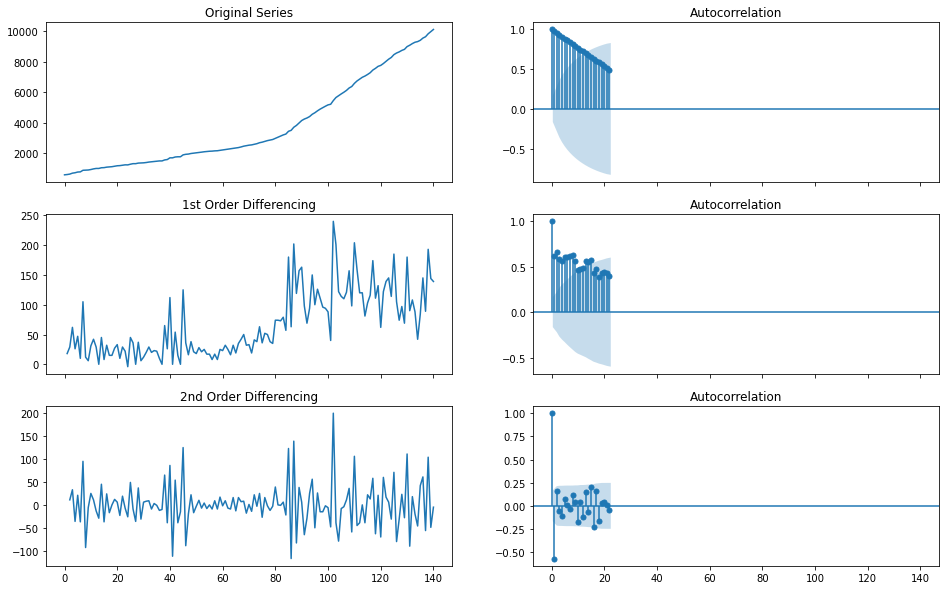

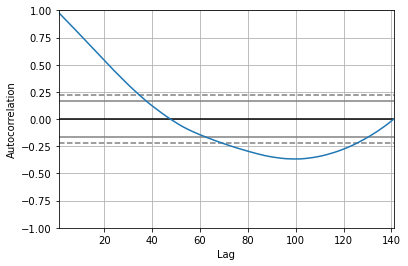

In [78]:
train_con = train_data[['Confirmed']].loc[train_data['West Virginia'] == 1].reset_index()
test_con = test_data[['Confirmed']].loc[test_data['West Virginia'] == 1].reset_index()

import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True, figsize = (16, 10))
axes[0, 0].plot(train_con.Confirmed); axes[0, 0].set_title('Original Series')
plot_acf(train_con.Confirmed, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(train_con.Confirmed.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(train_con.Confirmed.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(train_con.Confirmed.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train_con.Confirmed.diff().diff().dropna(), ax=axes[2, 1])
plt.show()

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train_con.Confirmed)
plt.show()

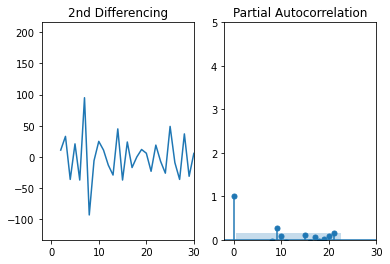

In [79]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train_con.Confirmed.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,5))
axes[1].set(xlim = (-2, 30))
plot_pacf(train_con.Confirmed.diff().diff().dropna(), ax=axes[1])

plt.show()

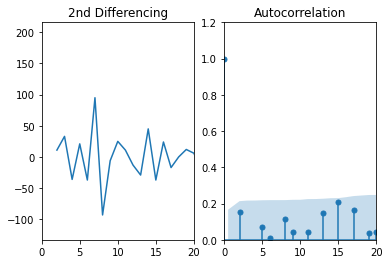

In [80]:
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(train_con.Confirmed.diff().diff()); axes[0].set_title('2nd Differencing')
axes[1].set(ylim=(0,1.2))
axes[1].set(xlim = (0, 20))
plot_acf(train_con.Confirmed.diff().diff().dropna(), ax=axes[1])

plt.show()

# LSTM RNN

## Tutorial

In [225]:
import os
import datetime

import IPython
import IPython.display
#import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

#mpl.rcParams['figure.figsize'] = (8, 6)
#mpl.rcParams['axes.grid'] = False

In [226]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [227]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


In [228]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

In [229]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

In [230]:
timestamp_s = date_time.map(datetime.datetime.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

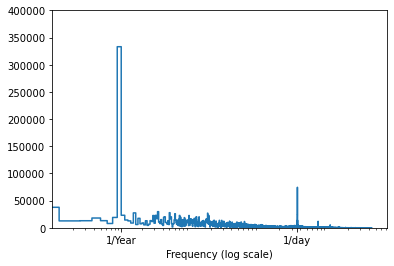

In [231]:
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['T (degC)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/Year', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

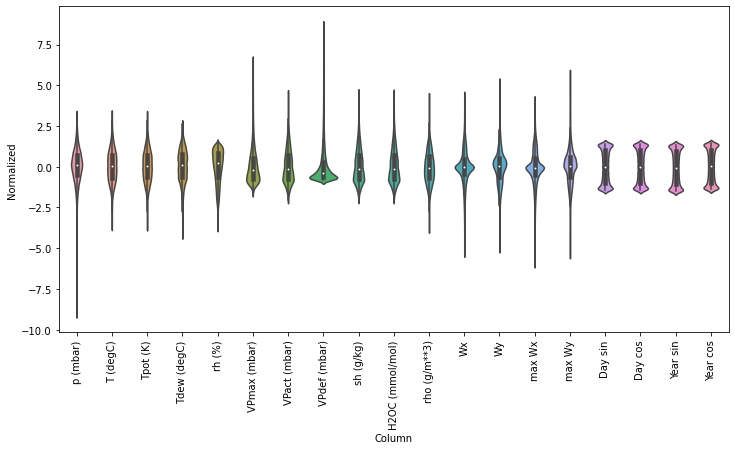

In [232]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [233]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168,-0.614587,-0.138503,7.071068e-01,-0.707107,0.015783,0.999875
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701,-0.619848,-0.112645,5.000000e-01,-0.866025,0.016500,0.999864
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879,-0.614344,0.139576,2.588190e-01,-0.965926,0.017216,0.999852
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603,-0.190000,-0.329090,6.903299e-12,-1.000000,0.017933,0.999839
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292,-0.810044,0.343843,-2.588190e-01,-0.965926,0.018650,0.999826


In [250]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
        train_df=train_df, val_df=val_df, test_df=test_df,
        label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [251]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['T (degC)'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['T (degC)']

In [252]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['T (degC)'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']

In [253]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    #print(self.column_indices)
    #print(self.label_columns)
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

In [254]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

w2.example = example_inputs, example_labels

All shapes are: (batch, time, features)
Window shape: (3, 7, 19)
Inputs shape: (3, 6, 19)
labels shape: (3, 1, 1)


In [255]:
def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

        plt.xlabel('Time [h]')

WindowGenerator.plot = plot

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['T (degC)']


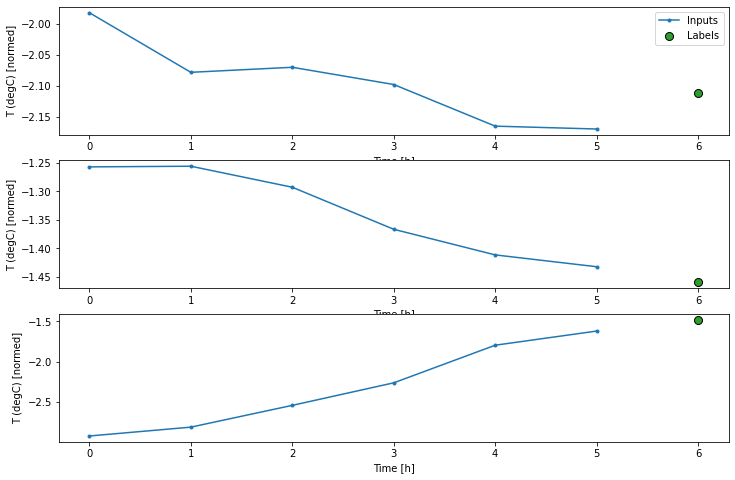

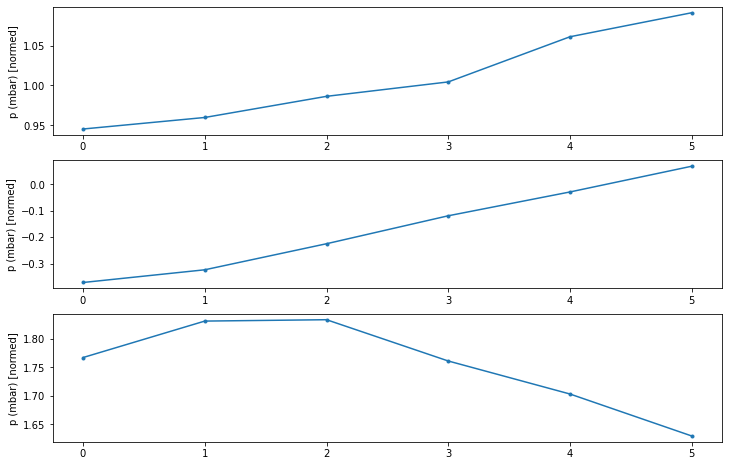

In [256]:
print(w2)
w2.plot()
w2.plot(plot_col='p (mbar)')

In [257]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [258]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [259]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 19), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [260]:
for example_inputs, example_labels in w2.train.take(2):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 6, 19)
Labels shape (batch, time, features): (32, 1, 1)


In [261]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [265]:
train_df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos
count,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04,4.906300e+04
mean,9.866828e-13,2.687906e-15,2.420228e-13,-1.608109e-15,-4.958723e-15,-1.225778e-14,3.104995e-15,1.443591e-15,-1.510789e-14,8.487758e-15,-2.021722e-13,-3.202316e-15,-2.139898e-15,1.321940e-15,-1.532802e-15,-2.645726e-17,1.614771e-17,1.668355e-16,1.853728e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-9.045695e+00,-3.682079e+00,-3.707266e+00,-4.216645e+00,-3.746587e+00,-1.609554e+00,-2.030996e+00,-8.298612e-01,-2.022853e+00,-2.031986e+00,-3.846513e+00,-5.321263e+00,-5.048245e+00,-5.972942e+00,-5.410607e+00,-1.414116e+00,-1.414231e+00,-1.502760e+00,-1.382546e+00
25%,-6.093840e-01,-7.069026e-01,-6.939982e-01,-6.697392e-01,-6.581569e-01,-7.505257e-01,-7.786971e-01,-6.575813e-01,-7.762466e-01,-7.761335e-01,-7.116941e-01,-4.375161e-01,-6.242102e-01,-4.814777e-01,-6.182100e-01,-9.998956e-01,-1.000033e+00,-9.853436e-01,-1.010625e+00
50%,5.467421e-02,9.450477e-03,1.318575e-02,5.168967e-02,1.989686e-01,-2.228923e-01,-1.561120e-01,-3.835939e-01,-1.548152e-01,-1.540757e-01,-7.847992e-02,-1.597386e-02,7.420737e-02,-4.660022e-02,8.077215e-02,1.215078e-04,-7.019891e-05,7.767211e-02,-1.468354e-02
75%,6.548575e-01,7.200265e-01,7.123465e-01,7.530390e-01,8.150841e-01,5.334687e-01,6.684569e-01,2.681639e-01,6.650251e-01,6.651626e-01,6.442168e-01,4.738166e-01,5.582518e-01,5.441849e-01,6.019162e-01,1.000139e+00,9.998924e-01,9.874625e-01,1.001995e+00
max,2.913378e+00,3.066661e+00,3.041354e+00,2.647686e+00,1.455361e+00,5.846190e+00,4.489514e+00,7.842254e+00,4.550843e+00,4.524268e+00,4.310438e+00,4.391051e+00,5.203526e+00,4.117034e+00,5.730397e+00,1.414359e+00,1.414090e+00,1.351647e+00,1.429049e+00


Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

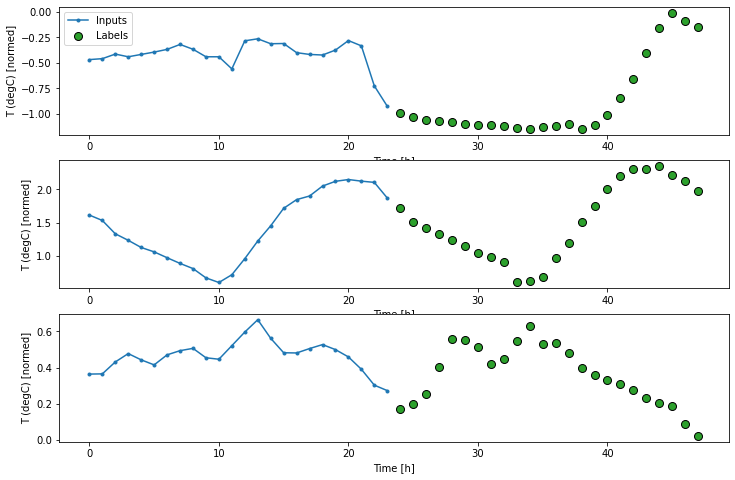

In [263]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

437/437 [==============================] - 0s 961us/step - loss: 0.6285 - mean_absolute_error: 0.5007


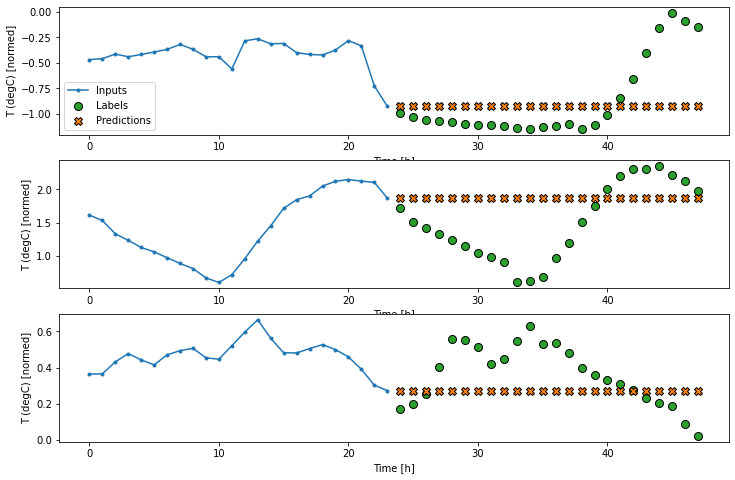

In [264]:
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

In [877]:
df_all = pd.read_csv('cleaned_train.csv', index_col = 0)
#print(df[['New_Confirmed', 'New_Deaths']])
df_all = df_all.loc[df_all['Province_State'] == 'California']
df = df_all[['New_Confirmed', 'New_Deaths']]
print(len(df))
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
p = 26
train_df = df[0:int(n - 2*p)]
val_df = df[int(n - 2*p):int(n - p)]
test_df = df[int(n - p):]

train_df.describe()

141


,New_Confirmed,New_Deaths
count,89.000000,89.000000
mean,3142.573034,69.876404
std,2391.741895,30.607790
min,0.000000,0.000000
25%,1649.000000,50.000000
50%,2295.000000,72.000000
75%,3570.000000,88.000000
max,12977.000000,145.000000


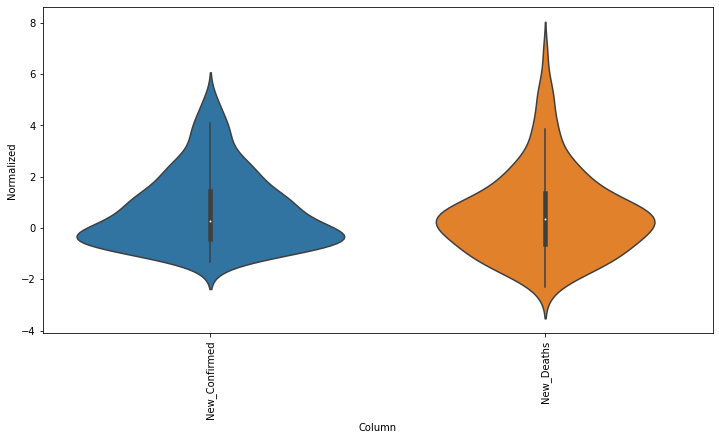

In [878]:
num_features = df.shape[1]

train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [879]:
train_df.describe()

,New_Confirmed,New_Deaths
count,8.900000e+01,8.900000e+01
mean,-7.484650e-17,-2.295293e-16
std,1.000000e+00,1.000000e+00
min,-1.313926e+00,-2.282961e+00
25%,-6.244708e-01,-6.493904e-01
50%,-3.543748e-01,6.938088e-02
75%,1.787095e-01,5.921236e-01
max,4.111826e+00,2.454395e+00


In [869]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
        train_df=train_df, val_df=val_df, test_df=test_df,
        label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    #print(self.column_indices)
    #print(self.label_columns)
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window

def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

        plt.xlabel('Time [h]')

WindowGenerator.plot = plot

def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

def compile_and_fit(model, window, maxepoch = MAX_EPOCHS, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=maxepoch,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [880]:
OUT_STEPS = 26
multi_window = WindowGenerator(input_width=26,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

#multi_window.plot(plot_col = 'New_Confirmed')
#multi_window

In [881]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)

In [882]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [883]:
OUT_STEPS = 26
multi_window = WindowGenerator(input_width=26,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

#multi_window.plot(plot_col = 'New_Confirmed')
multi_window

Total window size: 52
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51]
Label column name(s): None

In [884]:
def warmup(self, inputs):
    # inputs.shape => (batch, time, features)
    # x.shape => (batch, lstm_units)
    x, *state = self.lstm_rnn(inputs)

    # predictions.shape => (batch, features)
    prediction = self.dense(x)
    return prediction, state

FeedBack.warmup = warmup

In [885]:
def call(self, inputs, training=None):
    # Use a TensorArray to capture dynamically unrolled outputs.
    predictions = []
    # Initialize the lstm state
    prediction, state = self.warmup(inputs)

    # Insert the first prediction
    predictions.append(prediction)

    # Run the rest of the prediction steps
    for n in range(1, self.out_steps):
        # Use the last prediction as input.
        x = prediction
        # Execute one lstm step.
        x, state = self.lstm_cell(x, states=state,
                                  training=training)
        # Convert the lstm output to a prediction.
        prediction = self.dense(x)
        # Add the prediction to the output
        predictions.append(prediction)

    # predictions.shape => (time, batch, features)
    predictions = tf.stack(predictions)
    # predictions.shape => (batch, time, features)
    predictions = tf.transpose(predictions, [1, 0, 2])
    return predictions

FeedBack.call = call

Epoch 1/20
2/2 [==============================] - 0s 21ms/step - loss: 0.6842 - mean_absolute_error: 0.6011
Epoch 2/20
2/2 [==============================] - 0s 20ms/step - loss: 0.6791 - mean_absolute_error: 0.5988
Epoch 3/20
2/2 [==============================] - 0s 20ms/step - loss: 0.6736 - mean_absolute_error: 0.5961
Epoch 4/20
2/2 [==============================] - 0s 21ms/step - loss: 0.6678 - mean_absolute_error: 0.5931
Epoch 5/20
2/2 [==============================] - 0s 20ms/step - loss: 0.6618 - mean_absolute_error: 0.5895
Epoch 6/20
2/2 [==============================] - 0s 19ms/step - loss: 0.6554 - mean_absolute_error: 0.5854
Epoch 7/20
2/2 [==============================] - 0s 20ms/step - loss: 0.6483 - mean_absolute_error: 0.5802
Epoch 8/20
2/2 [==============================] - 0s 19ms/step - loss: 0.6388 - mean_absolute_error: 0.5743
Epoch 9/20
2/2 [==============================] - 0s 19ms/step - loss: 0.6286 - mean_absolute_error: 0.5676
Epoch 10/20
2/2 [===========

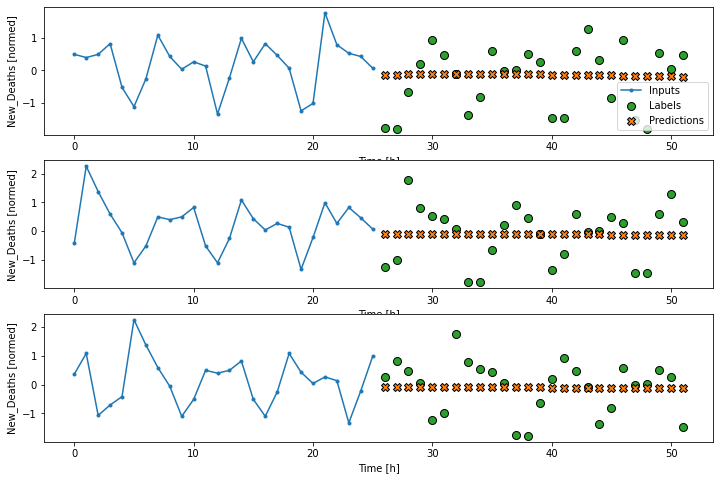

In [886]:
history = compile_and_fit(feedback_model, multi_window)

#IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, verbose = 0)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose = 0)
multi_window.plot(feedback_model, plot_col = 'New_Deaths')

In [887]:
df2 = pd.read_csv('cleaned_test.csv', index_col = 0)
#print(df[['New_Confirmed', 'New_Deaths']])
df2 = df2.loc[df2['Province_State'] == 'California']
print(df2.head())

     Province_State          Last_Update      Lat     Long_  Confirmed  \
7054     California  2020-09-01 04:30:22  36.1162 -119.6816   712475.0   
7104     California  2020-09-02 04:30:23  36.1162 -119.6816   715617.0   
7154     California  2020-09-03 04:30:31  36.1162 -119.6816   721281.0   
7204     California  2020-09-04 04:30:31  36.1162 -119.6816   726018.0   
7254     California  2020-09-05 04:30:29  36.1162 -119.6816   730662.0   

       Deaths  Recovered    Active  Incident_Rate  People_Tested  ...  \
7054  13022.0    77165.9  699453.0    1803.176197     11373305.0  ...   
7104  13150.0    77245.6  702467.0    1811.128167     11470696.0  ...   
7154  13317.0    77325.3  707964.0    1825.462971     11580370.0  ...   
7204  13493.0    77400.4  712525.0    1837.451667     11663924.0  ...   
7254  13638.0    77478.4  717024.0    1849.204992     11796970.0  ...   

      Washington  West Virginia  Wisconsin  Wyoming  dem  rep  swing  mask  \
7054         0.0            0.0       

In [888]:
pred = feedback_model.predict(tf.expand_dims(tf.constant(test_df), axis = 0))[0]
for i in range(len(pred)):
    pred[i] = pred[i] * train_std + train_mean
#pred


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [889]:
pred = np.concatenate((df_all[['Confirmed', 'Deaths']].iloc[[len(df_all) - 1]], pred), axis=0).cumsum(axis = 0).round()[1:]
pred

array([[711231.,  12995.],
       [716697.,  13055.],
       [722375.,  13116.],
       [728259.,  13177.],
       [734336.,  13239.],
       [740586.,  13302.],
       [746989.,  13365.],
       [753527.,  13428.],
       [760183.,  13492.],
       [766942.,  13556.],
       [773791.,  13620.],
       [780718.,  13684.],
       [787713.,  13749.],
       [794769.,  13813.],
       [801876.,  13878.],
       [809030.,  13942.],
       [816223.,  14007.],
       [823452.,  14072.],
       [830713.,  14136.],
       [838000.,  14201.],
       [845313.,  14266.],
       [852646.,  14331.],
       [859999.,  14396.],
       [867368.,  14461.],
       [874752.,  14525.],
       [882149.,  14590.]])

In [890]:
df2['Confirmed']

7054    712475.0
7104    715617.0
7154    721281.0
7204    726018.0
7254    730662.0
7304    735314.0
7354    738856.0
7404    740965.0
7454    744344.0
7504    747290.0
7554    750961.0
7604    754905.0
7654    758933.0
7704    761728.0
7754    765134.0
7804    768204.0
7854    771321.0
7904    775037.0
7954    779491.0
8004    783313.0
8054    786168.0
8104    790096.0
8154    793065.0
8204    796436.0
8254    799516.0
8304    803660.0
Name: Confirmed, dtype: float64

In [891]:
mape = np.absolute((pred[:,0] - df2['Confirmed'])) / np.array(df2['Confirmed'])
mape = np.sum(mape, axis = 0) / len(df2['Confirmed'])
#mape = np.sum(mape) / (2 * len(pred2))
mape

0.0430188047547175

In [906]:
import datetime
base = datetime.date(2020, 9, 1)
date_list = [base + datetime.timedelta(days=x) for x in range(26)]
for i in range(len(date_list)):
    date_list[i] = date_list[i].strftime("%m/%d/%Y")
numdays = 26

In [1005]:
df_all = pd.read_csv('cleaned_train.csv', index_col = 0)
statenames = np.unique(df_all['Province_State'])
OUT_STEPS = 26
MAX_EPOCH = 50
predictions = pd.DataFrame(columns = ['Province_State', 'Date', 'Confirmed', 'Deaths'])

for state in statenames:
    temp = pd.concat([pd.Series(np.repeat(state, repeats = numdays)), pd.Series(date_list)], axis = 1)
    statedata_all = df_all.loc[df_all['Province_State'] == state]
    statedata = statedata_all[['New_Confirmed', 'New_Deaths']]
    
    column_indices = {name: i for i, name in enumerate(df.columns)}
    n = len(statedata)
    p = 26
    train_df = statedata[0:int(n - 2*p)]
    val_df = statedata[int(n - 2*p):int(n - p)]
    test_df = statedata[int(n - p):]

    num_features = statedata.shape[1]

    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    multi_window = WindowGenerator(input_width=5, label_width=OUT_STEPS, shift=OUT_STEPS, 
                               train_df = train_df, val_df = val_df, test_df = test_df)
    
    feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
    history = compile_and_fit(feedback_model, multi_window, MAX_EPOCH)

    IPython.display.clear_output()

    multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, verbose = 0)
    multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose = 0)
    
    pred = feedback_model.predict(tf.expand_dims(tf.constant(test_df), axis = 0))[0]
    for i in range(len(pred)):
        pred[i] = pred[i] * train_std + train_mean

    pred = np.concatenate((statedata_all[['Confirmed', 'Deaths']].iloc[[len(statedata_all) - 1]], pred), axis=0).cumsum(axis = 0).round()[1:]
    df2 = pd.read_csv('cleaned_test.csv', index_col = 0)
    df2 = df2.loc[df2['Province_State'] == state]
    #print(pred)
    temp = pd.concat([temp, pd.DataFrame(pred, columns = ['Confirmed', 'Deaths'])], axis = 1)
    temp.columns = ['Province_State', 'Date', 'Confirmed', 'Deaths']
    predictions = predictions.append(temp)
    #mape = np.absolute((pred[:,0] - df2['Confirmed'])) / np.array(df2['Confirmed'])
    mape = np.absolute((pred - np.array(df2[['Confirmed', 'Deaths']]))) / np.array(df2[['Confirmed', 'Deaths']])
    mape = np.sum(mape, axis = 0) / len(df2['Confirmed'])

In [1006]:
predictions

,Province_State,Date,Confirmed,Deaths
0,Alabama,09/01/2020,126201.0,2168.0
1,Alabama,09/02/2020,127224.0,2175.0
2,Alabama,09/03/2020,128285.0,2183.0
3,Alabama,09/04/2020,129372.0,2193.0
4,Alabama,09/05/2020,130474.0,2203.0
...,...,...,...,...
21,Wyoming,09/22/2020,4091.0,38.0
22,Wyoming,09/23/2020,4097.0,38.0
23,Wyoming,09/24/2020,4102.0,39.0
24,Wyoming,09/25/2020,4106.0,40.0


In [1007]:
temp = pd.read_csv('cleaned_test.csv', index_col = 0)
temp[['Confirmed', 'Deaths']]

,Confirmed,Deaths
7050,126058.0,2182.0
7051,5263.0,37.0
7052,201835.0,5029.0
7053,61224.0,797.0
7054,712475.0,13022.0
...,...,...
8345,144294.0,3134.0
8346,85226.0,2100.0
8347,14962.0,335.0
8348,110828.0,1274.0


In [1008]:
pred2 = predictions
pred2 = pred2.sort_values(by = ['Date', 'Province_State']).reset_index(drop = True)
pred2 = pred2.drop(columns = ['Province_State', 'Date'])
pred2.index.name = 'ForecastID'
mape = np.absolute((pred2 - np.array(temp[['Confirmed', 'Deaths']]))) / np.array(temp[['Confirmed', 'Deaths']])
mape = np.sum(mape, axis = 0) / len(pred2)
mape

Confirmed    0.055975
Deaths       0.067088
dtype: float64

In [1009]:
pred2 = predictions
pred2 = pred2.sort_values(by = ['Date', 'Province_State']).reset_index(drop = True)

actual = temp[['Confirmed', 'Deaths']].reset_index(drop = True)
pred2['mapeConfirm'] = np.absolute(pred2[['Confirmed']] - actual[['Confirmed']]) / actual[['Confirmed']] * 100
pred2['mapeDeaths'] = np.absolute(pred2[['Deaths']] - actual[['Deaths']]) / actual[['Deaths']] * 100

pred2.groupby(by = 'Province_State').mean()

,Confirmed,Deaths,mapeConfirm,mapeDeaths
Province_State,,,,
Alabama,139931.153846,2305.653846,1.382980,1.783609
Alaska,5651.615385,40.692308,8.632654,5.597194
Arizona,199151.807692,5202.500000,4.638126,2.159119
Arkansas,69105.692308,854.730769,1.403114,15.484800
California,789989.269231,13808.884615,3.901127,3.559808
Colorado,60851.500000,2139.269231,1.420905,7.477251
Connecticut,53370.192308,4537.307692,2.184872,1.248958
Delaware,18533.461538,679.230769,1.174081,10.261357
Florida,627733.153846,11577.115385,5.157639,7.548649


In [979]:
pred2.to_csv("Team1_LSTM.csv")

In [988]:
import logging
def set_tf_loglevel(level):
    if level >= logging.FATAL:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    if level >= logging.ERROR:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
    if level >= logging.WARNING:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
    else:
        os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'
    logging.getLogger('tensorflow').setLevel(level)
set_tf_loglevel(logging.FATAL)

[19.19085546 26.62316967]


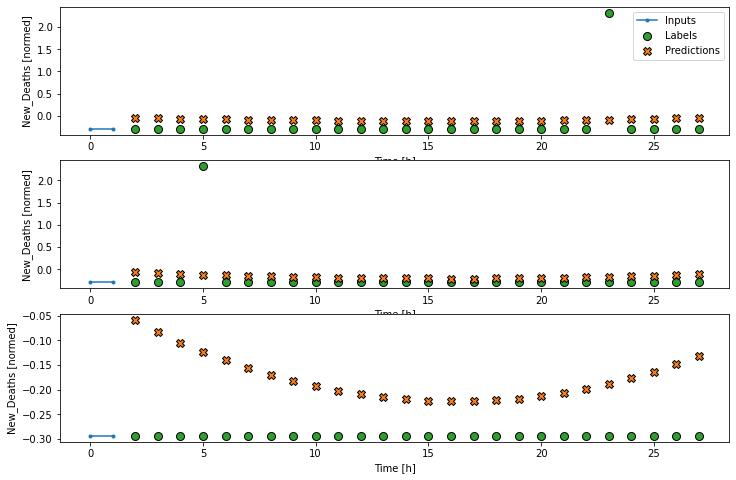

In [1063]:
df_all = pd.read_csv('cleaned_train.csv', index_col = 0)
statenames = np.unique(df_all['Province_State'])
OUT_STEPS = 26
MAX_EPOCH = 50

for state in ['Hawaii']:
    statedata_all = df_all.loc[df_all['Province_State'] == state]
    statedata = statedata_all[['New_Confirmed', 'New_Deaths']]
    
    column_indices = {name: i for i, name in enumerate(df.columns)}
    n = len(statedata)
    p = 26
    train_df = statedata[0:int(n - 2*p)]
    val_df = statedata[int(n - 2*p):int(n - p)]
    test_df = statedata[int(n - p):]

    num_features = statedata.shape[1]

    train_mean = train_df.mean()
    train_std = train_df.std()

    train_df = (train_df - train_mean) / train_std
    val_df = (val_df - train_mean) / train_std
    test_df = (test_df - train_mean) / train_std
    
    multi_window = WindowGenerator(input_width=2, label_width=OUT_STEPS, shift=OUT_STEPS, 
                               train_df = train_df, val_df = val_df, test_df = test_df)
    
    feedback_model = FeedBack(units=40, out_steps=OUT_STEPS)
    history = compile_and_fit(feedback_model, multi_window, MAX_EPOCH)

    IPython.display.clear_output()

    multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val, verbose = 0)
    multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose = 0)
    multi_window.plot(feedback_model, plot_col = 'New_Deaths')
    
    pred = feedback_model.predict(tf.expand_dims(tf.constant(test_df), axis = 0))[0]
    #print(statedata)
    for i in range(len(pred)):
        pred[i] = pred[i] * train_std + train_mean
    #print(pred)

    pred = np.concatenate((statedata_all[['Confirmed', 'Deaths']].iloc[[len(statedata_all) - 1]], pred), axis=0).cumsum(axis = 0).round()[1:]
    df2 = pd.read_csv('cleaned_test.csv', index_col = 0)
    df2 = df2.loc[df2['Province_State'] == state]
    #print(pred)
    #print(df2[['Confirmed', 'Deaths']])
    
    #mape = np.absolute((pred[:,0] - df2['Confirmed'])) / np.array(df2['Confirmed'])
    mape = np.absolute((pred - np.array(df2[['Confirmed', 'Deaths']]))) / np.array(df2[['Confirmed', 'Deaths']])
    mape = np.sum(mape, axis = 0) / len(df2['Confirmed'])
    print(mape * 100)

In [1053]:
statedata_all = df_all.loc[df_all['Province_State'] == 'Hawaii']
#statedata = statedata[['New_Confirmed', 'New_Deaths']]
statedata_all

,Province_State,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,...,Washington,West Virginia,Wisconsin,Wyoming,dem,rep,swing,mask,New_Confirmed,New_Deaths
10,Hawaii,2020-04-12 23:18:15,21.0943,-157.4983,499.0,9.0,300.0,490.0,35.245440,17968.0,...,0.0,0.0,0.0,0.0,3,0,0,1,0.0,0.0
60,Hawaii,2020-04-13 23:07:54,21.0943,-157.4983,504.0,9.0,310.0,495.0,35.598600,18844.0,...,0.0,0.0,0.0,0.0,3,0,0,1,5.0,0.0
110,Hawaii,2020-04-14 23:33:31,21.0943,-157.4983,511.0,9.0,315.0,502.0,36.093025,19420.0,...,0.0,0.0,0.0,0.0,3,0,0,1,7.0,0.0
160,Hawaii,2020-04-15 22:56:51,21.0943,-157.4983,524.0,9.0,333.0,515.0,37.011243,19803.0,...,0.0,0.0,0.0,0.0,3,0,0,1,13.0,0.0
210,Hawaii,2020-04-16 23:30:51,21.0943,-157.4983,530.0,9.0,359.0,521.0,37.435036,20700.0,...,0.0,0.0,0.0,0.0,3,0,0,1,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6810,Hawaii,2020-08-27 04:30:22,21.0943,-157.4983,7260.0,51.0,2236.0,4973.0,512.758215,183157.0,...,0.0,0.0,0.0,0.0,3,0,0,1,276.0,2.0
6860,Hawaii,2020-08-28 04:30:22,21.0943,-157.4983,7566.0,55.0,2288.0,5223.0,534.370339,185675.0,...,0.0,0.0,0.0,0.0,3,0,0,1,306.0,4.0
6910,Hawaii,2020-08-29 04:30:22,21.0943,-157.4983,7830.0,59.0,2371.0,5400.0,553.016092,188153.0,...,0.0,0.0,0.0,0.0,3,0,0,1,264.0,4.0
6960,Hawaii,2020-08-30 04:30:24,21.0943,-157.4983,8139.0,62.0,2410.0,5667.0,574.840099,190910.0,...,0.0,0.0,0.0,0.0,3,0,0,1,309.0,3.0


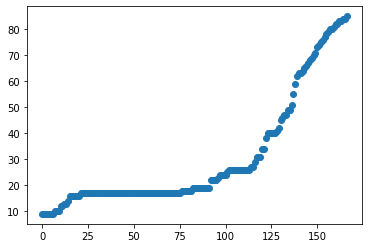

In [1054]:
plt.scatter(range(len(statedata_all) + 26), np.append(statedata_all['Deaths'], pred[:,1]))

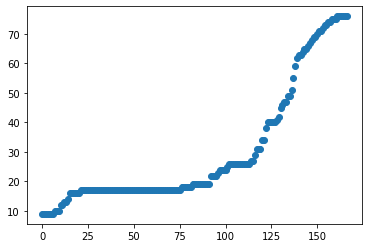

In [1064]:
plt.scatter(range(len(statedata_all) + 26), np.append(statedata_all['Deaths'], pred[:,1]))

In [1059]:
statedata_all['Deaths']

10       9.0
60       9.0
110      9.0
160      9.0
210      9.0
        ... 
6810    51.0
6860    55.0
6910    59.0
6960    62.0
7010    63.0
Name: Deaths, Length: 141, dtype: float64

In [1060]:
pred[:,1]

array([63., 64., 65., 66., 67., 68., 69., 70., 71., 73., 74., 75., 76.,
       77., 78., 79., 80., 80., 81., 82., 82., 83., 83., 84., 84., 85.])

In [1067]:
np.reshape(statedata_all['Confirmed'], (statedata_all['Confirmed'].shape[0], 1, statedata_all['Confirmed'].shape[1]))

ValueError: Must pass 2-d input